# Macro factors of the risk-parity trade

This notebook serves as an illustration of the points discussed in the post ["Macro factors of the risk-parity trade"](https://research.macrosynergy.com/macro-factors-for-the-risk-parity-trade/) available on the Macrosynergy website. 

Risk parity positioning in equity and fixed income duration is a portfolio construction strategy that aims to allocate assets in a way that balances risk contributions between the two asset classes. The primary goal of risk parity is to achieve a more diversified and risk-efficient portfolio by distributing risk equally or proportionally across different asset categories. Risk-parity positioning in equity and (fixed income) duration has been a popular and successful investment strategy in past decades. However, part of that success is owed to a supportive macro environment, with accommodative refinancing conditions and slow, disinflationary, or even deflationary economies. Financial and economic shocks, as opposed to inflation shocks, dominated markets, leading to a negative equity-duration correlation. The macro environment is changeable, however, and a strong theoretical case can be made for managing risk-parity strategies based on economic trends and risk-adjusted carry. We propose simple strategies based on macro-quantamental indicators of economic overheating. Overheating scores have been strongly correlated with risk parity performance and macro-based management would have benefited risk parity performance even during the past two "golden decades" of risk parity.

This notebook provides the essential code required to replicate the analysis discussed in the post.  

The notebook covers the three main parts:

- Get Packages and JPMaQS Data: This section is responsible for installing and importing the necessary Python packages used throughout the analysis. 

- Transformations and Checks: In this part, the notebook performs calculations and transformations on the data to derive the relevant signals and targets used for the analysis, including the normalization of feature variables using z-score or building simple linear composite indicators.

- Value Checks: This is the most critical section, where the notebook calculates and implements the trading strategies based on the hypotheses tested in the post. This section involves backtesting a few simple but powerful trading strategies targeting selected financial returns.

It is important to note that while the notebook covers a selection of indicators and strategies used for the post's main findings, users can explore countless other possible indicators and approaches. Users can modify the code to test different hypotheses and strategies based on their research and ideas. For example, this notebook focuses on the main developed markets. Similar analysis can be extended for other currencies and regions. Best of luck with your research!

## Get packages and JPMaQS data

This notebook primarily relies on the standard packages available in the Python data science stack. However, there is an additional package `macrosynergy` that is required for two purposes:

- Downloading JPMaQS data: The `macrosynergy` package facilitates the retrieval of JPMaQS data, which is required in the notebook.

- For the analysis of quantamental data and value propositions: The `macrosynergy` package provides functionality for performing quick analyses of quantamental data and exploring value propositions.

For detailed information and a comprehensive understanding of the `macrosynergy` package and its functionalities, please refer to the [“Introduction to Macrosynergy package”](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php) notebook on the Macrosynergy Quantamental Academy or visit the following link on [Kaggle](https://www.kaggle.com/code/macrosynergy/introduction-to-macrosynergy-package).

In [1]:
"""! pip install macrosynergy --upgrade"""

'! pip install macrosynergy --upgrade'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn

from macrosynergy.download import JPMaQSDownload

import warnings

warnings.simplefilter("ignore")

The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

`value` giving the latest available values for the indicator
`eop_lag` referring to days elapsed since the end of the observation period
`mop_lag` referring to the number of days elapsed since the mean observation period
`grade` denoting a grade of the observation, giving a metric of real-time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md)

In [3]:
# For this post we focus on a selection of major developed markets currencies (in alphabetical order) - AUD (Australian dollar), CAD (Canadian dollar), CHF (Swiss franc), EUR (euro), GBP (British pound), JPY (Japanese yen), SEK (Swedish krona) and USD (U.S. dollar).

cids = ["AUD", "CAD", "CHF", "EUR", "GBP", "JPY", "SEK", "USD"]

In [4]:
# Category tickers

main = [
    "EMPL_NSA_P1M1ML12_3MMA",
    "EMPL_NSA_P1Q1QL4",
    "UNEMPLRATE_SA_3MMAv5YMM",
    "CPIH_SJA_P6M6ML6AR",
    "INFTEFF_NSA",
    "INTRGDPv5Y_NSA_P1M1ML12_3MMA",
    "RGDP_SA_P1Q1QL4_20QMM",
    "PCREDITBN_SJA_P1M1ML12",
]
xtra = ["EQCRY_VT10", "DU05YCRY_VT10"]

rets = ["EQXR_NSA", "EQXR_VT10", "DU05YXR_VT10"]

xcats = main + rets + xtra

# Resultant tickers

tickers = [cid + "_" + xcat for cid in cids for xcat in xcats]
print(f"Maximum number of tickers is {len(tickers)}")

Maximum number of tickers is 104


JPMaQS indicators are conveniently grouped into six main categories: Economic Trends, Macroeconomic balance sheets, Financial conditions, Shocks and risk measures, Stylized trading factors, and Generic returns. Each indicator has a separate page with notes, description, availability, statistical measures, and timelines for main currencies. The description of each JPMaQS category is available under [Macro quantamental academy](https://academy.macrosynergy.com/quantamental-indicators/). For tickers used in this notebook see [Employment growth](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Labor%20market%20dynamics.php), [Private credit expansion](https://academy.macrosynergy.com/academy/Themes/Financial%20conditions/_build/html/notebooks/Private%20credit%20expansion.php), [Consumer price inflation trends](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Consumer%20price%20inflation%20trends.php), [Inflation targets](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Inflation%20targets.php), [Intuitive growth estimates](https://macrosynergy.com/academy/notebooks/intuitive-gdp-growth-estimates/), [Long-term GDP growth](https://macrosynergy.com/academy/notebooks/gdp-growth/), [Equity index future carry](https://academy.macrosynergy.com/academy/Themes/Stylized%20trading%20factors/_build/html/notebooks/Equity%20index%20future%20carry.php),   [Duration returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Equity%20index%20future%20returns.php), and  [Equity index future returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Equity%20index%20future%20returns.php).

In [5]:
#  Download series from J.P. Morgan DataQuery by tickers

start_date = "1990-01-01"
end_date = "2023-07-01"


# Retrieve credentials
client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as dq:
    df = dq.download(
        tickers=tickers,
        start_date=start_date,
        suppress_warning=True,
        metrics=["all"],
        show_progress=True,
    )

Timestamp UTC:  2024-03-21 14:48:09
Connection successful!


Requesting data: 100%|██████████| 21/21 [00:04<00:00,  4.91it/s]


Some expressions are missing from the downloaded data. Check logger output for complete list.
32 out of 416 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.
Some dates are missing from the downloaded data. 
2 out of 8931 dates are missing.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715255 entries, 0 to 715254
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   real_date  715255 non-null  datetime64[ns]
 1   cid        715255 non-null  object        
 2   xcat       715255 non-null  object        
 3   eop_lag    715255 non-null  float64       
 4   grading    715255 non-null  float64       
 5   mop_lag    715255 non-null  float64       
 6   value      715255 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 38.2+ MB


The following cell extracts four standard columns (cross-section identifier, category, date, and value) and then consolidates them into a fresh dataframe. We won't be considering any other metrics (such as grading, eop_lag, and mop_lag) for our analysis.

In [7]:
scols = ["cid", "xcat", "real_date", "value"]  # required columns
dfx = df[scols].copy()
dfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715255 entries, 0 to 715254
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   cid        715255 non-null  object        
 1   xcat       715255 non-null  object        
 2   real_date  715255 non-null  datetime64[ns]
 3   value      715255 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 21.8+ MB


### Availability

Prior to commencing any analysis, it is crucial to evaluate the accessibility of data. This evaluation serves several purposes, including the identification of potential data gaps or constraints within the dataset. Such gaps can significantly influence the trustworthiness and accuracy of the analysis. Moreover, it aids in verifying that an ample number of observations are accessible for each chosen category and cross-section. Additionally, it assists in establishing suitable timeframes for conducting the analysis.

In [8]:
msm.missing_in_df(df, xcats=xcats, cids=cids)

Missing xcats across df:  []
Missing cids for CPIH_SJA_P6M6ML6AR:  []
Missing cids for DU05YCRY_VT10:  []
Missing cids for DU05YXR_VT10:  []
Missing cids for EMPL_NSA_P1M1ML12_3MMA:  ['CHF', 'EUR']
Missing cids for EMPL_NSA_P1Q1QL4:  ['CAD', 'JPY', 'AUD', 'USD', 'GBP', 'SEK']
Missing cids for EQCRY_VT10:  []
Missing cids for EQXR_NSA:  []
Missing cids for EQXR_VT10:  []
Missing cids for INFTEFF_NSA:  []
Missing cids for INTRGDPv5Y_NSA_P1M1ML12_3MMA:  []
Missing cids for PCREDITBN_SJA_P1M1ML12:  []
Missing cids for RGDP_SA_P1Q1QL4_20QMM:  []
Missing cids for UNEMPLRATE_SA_3MMAv5YMM:  []


It is important to note that when conducting labor market analysis or comparing labor market dynamics across different countries, the frequency and availability of data can significantly impact the analysis. From the availability table below, we can see that the majority of selected countries provide labor market dynamics indicators (in particular, Employment growth), on monthly basis, with fairly short publication lags. However, Switzerland (CHF) and the Eurozone (EUR) only release quarterly data. There are no employment growth rates on a monthly frequency for these countries. This will need to be accounted for in the analysis later on.

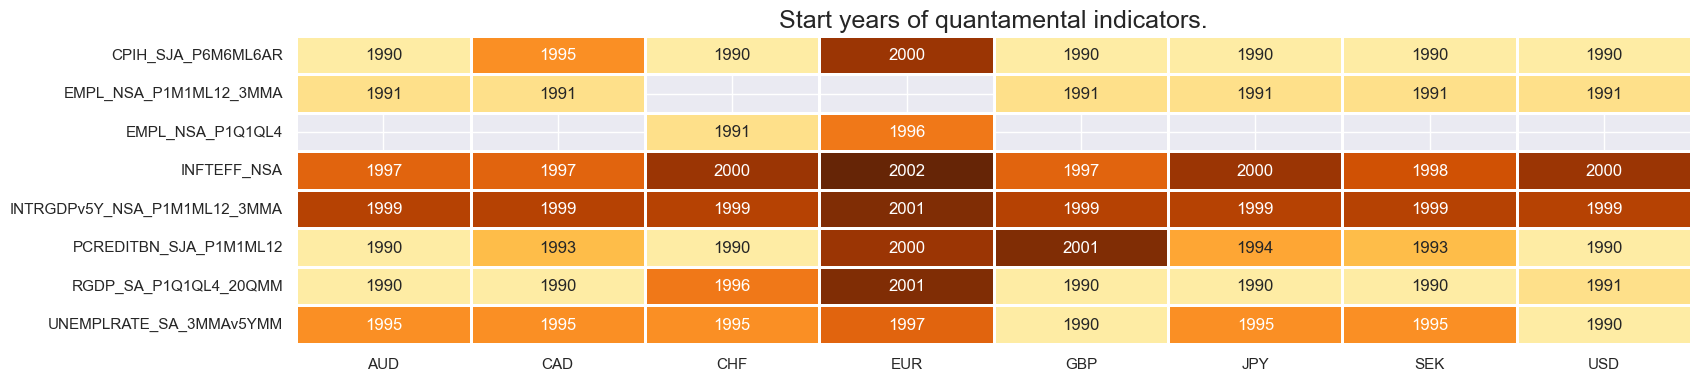

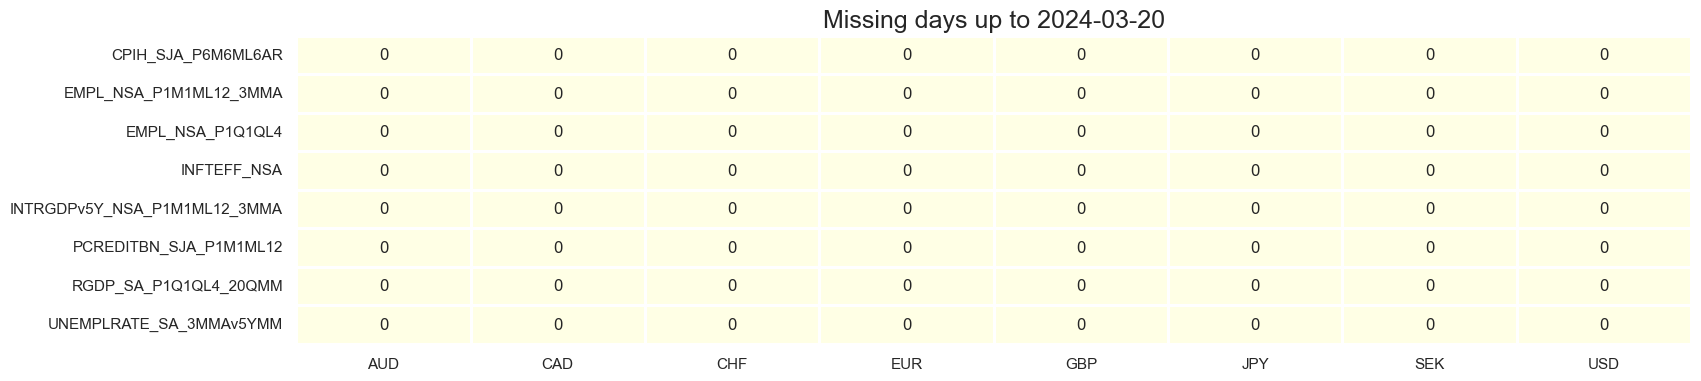

In [9]:
msm.check_availability(df, xcats=main, cids=cids)

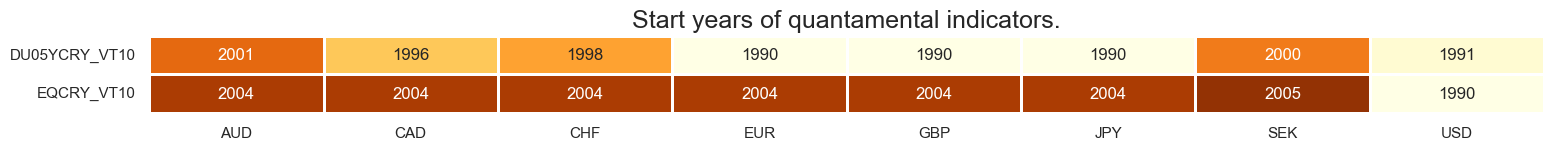

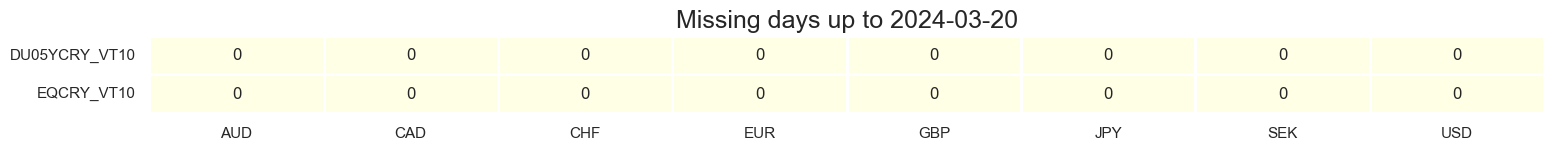

In [10]:
msm.check_availability(df, xcats=xtra, cids=cids)

## Transformations and checks

### Excess growth

We start by displaying the timeline for excess growth of real GDP for major economies. Luckily, this group of indicators is readily available in JPMaQS and does not need any transformation. Please see description for excess intuitive growth indicator on page [Excess intuitive growth](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Intuitive%20growth%20estimates.php). In particular we look at the Excess intuitive real GDP growth trend: based on 5-year lookback (`INTRGDPv5Y_NSA_P1M1ML12_3MMA`). This indicator is displayed with the help of [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) function from the `macrosynergy` package.

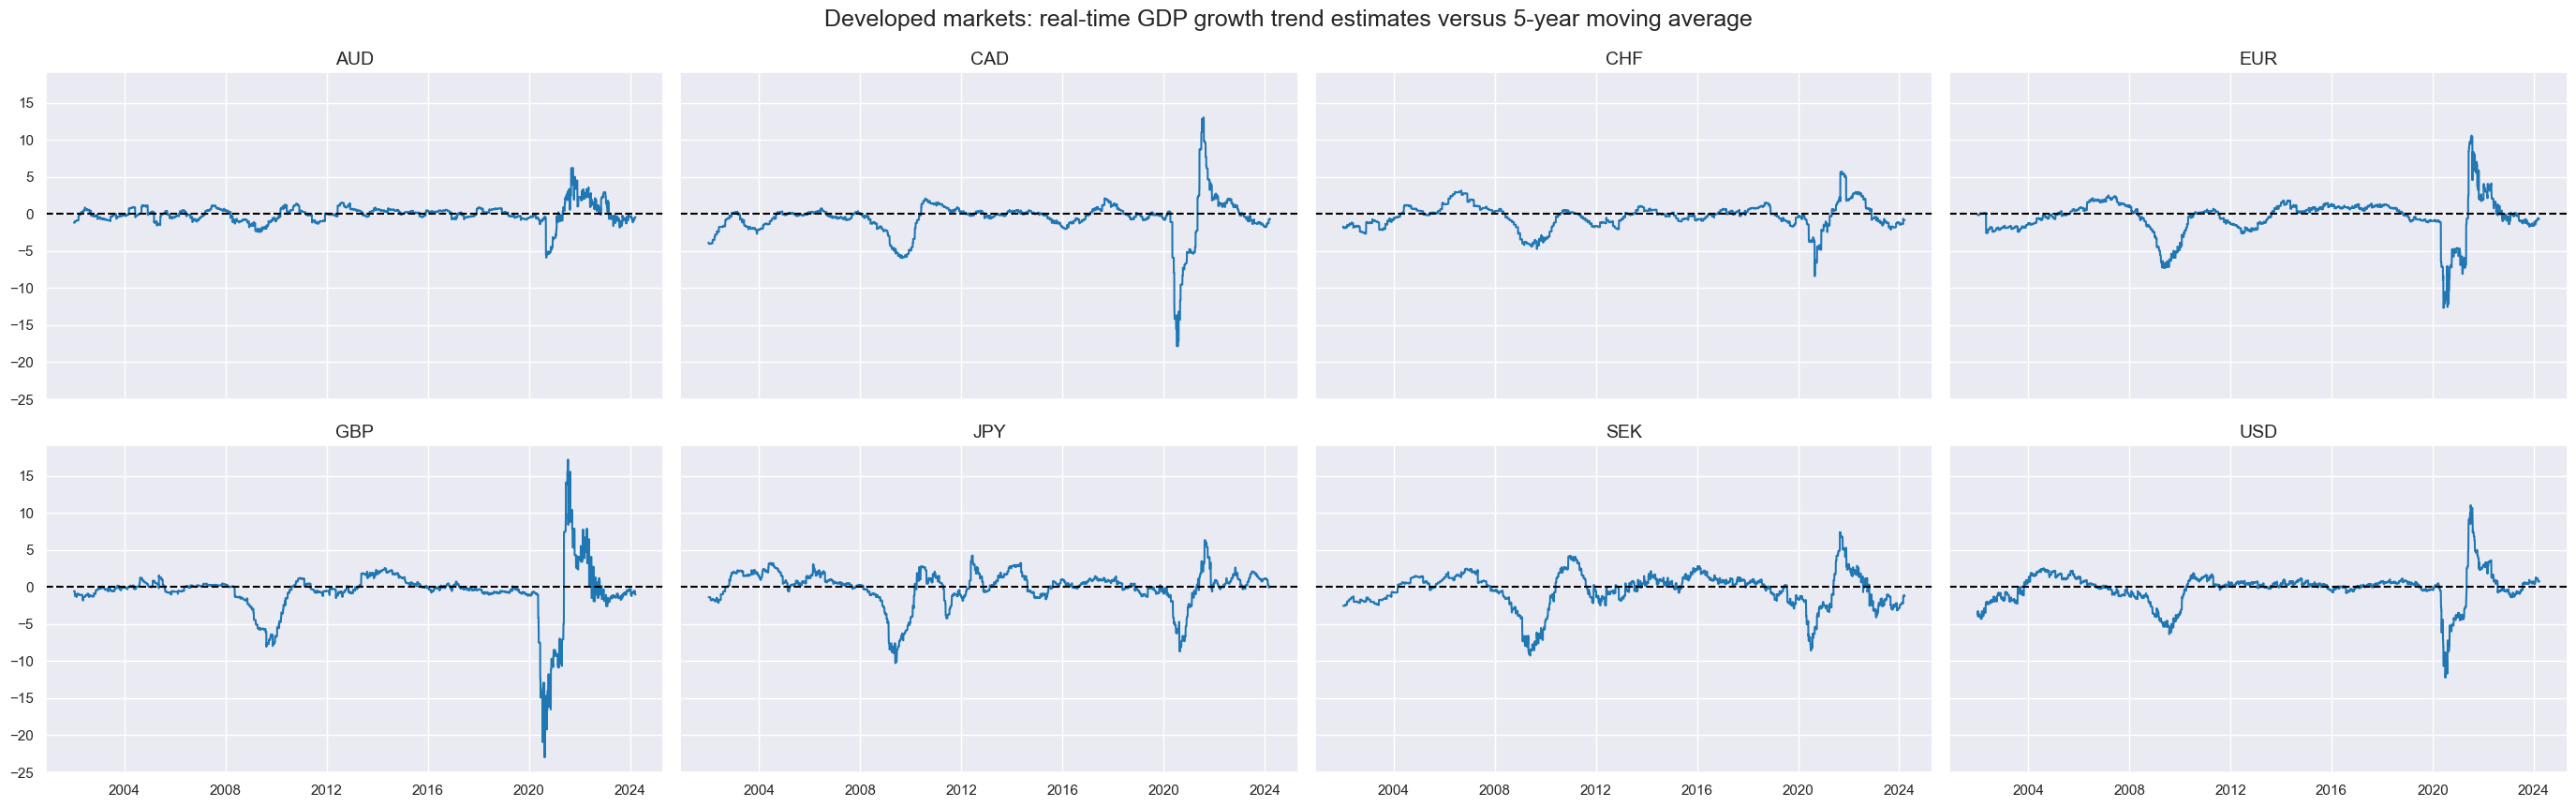

In [11]:
xcatx = ["INTRGDPv5Y_NSA_P1M1ML12_3MMA"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cids,
    ncol=4,
    cumsum=False,
    start="2002-01-01",
    same_y=True,
    all_xticks=False,
    title="Developed markets: real-time GDP growth trend estimates versus 5-year moving average",
)

### Excess inflation

We calculate the inflation trend using daily real-time data from the most recent headline consumer price index values. This trend is expressed as the seasonally- and jump-adjusted percentage change over the latest six months compared to the previous six months, annualized. Excess inflation is determined by subtracting the [Effective inflation target](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Inflation%20targets.php#effective-inflation-target) from this inflation trend. The effective inflation target comprises two components: the estimated official inflation target and an adjustment for historical "target misses." This adjustment is derived from the average gap between actual inflation and the estimated official target mean over the past three years.
To facilitate comparisons between countries with varying inflation rates, we normalize excess inflation by dividing it by the maximum value between 2 and the inflation target. This standardization ensures a consistent basis for assessing and comparing excess inflation across countries. The new indicator receives the name `XCPIH_SJA_P6M6ML6AR`, and its timeline is displayed with the help of [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) function from the `macrosynergy` package.

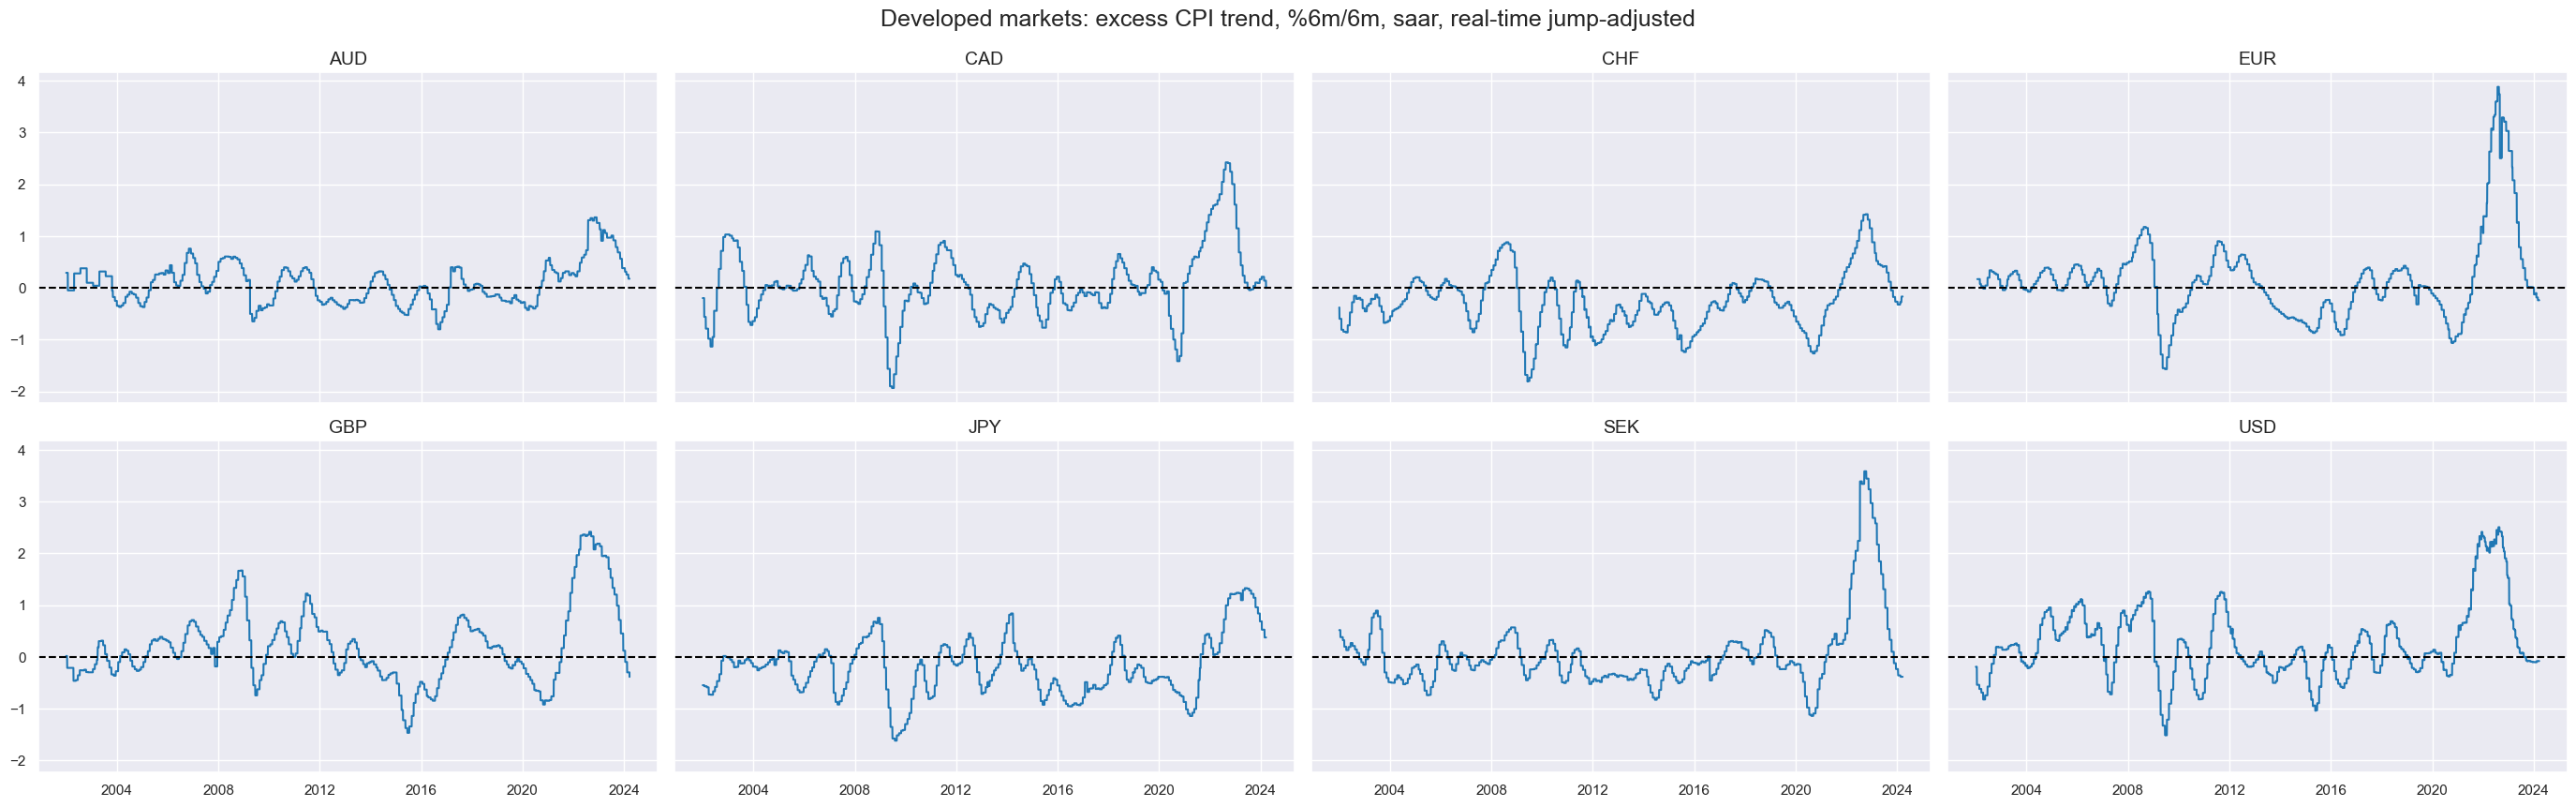

In [12]:
dfa = msp.panel_calculator(
    dfx,
    ["INFTEBASIS = INFTEFF_NSA.clip(lower=2)"],
    cids=cids,
)
dfx = msm.update_df(dfx, dfa)

infs = [
    "CPIH_SJA_P6M6ML6AR",
]

for inf in infs:
    calc_iet = f"X{inf} = ( {inf} - INFTEFF_NSA ) / INFTEBASIS"
    dfa = msp.panel_calculator(dfx, calcs=[calc_iet], cids=cids)
    dfx = msm.update_df(dfx, dfa)

xcatx = ["XCPIH_SJA_P6M6ML6AR"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cids,
    ncol=4,
    cumsum=False,
    start="2002-01-01",
    same_y=True,
    all_xticks=False,
    title="Developed markets: excess CPI trend, %6m/6m, saar, real-time jump-adjusted",
)

### Excess private credit growth

Credit growth here means real-time information on private bank credit at the end of the latest reported month, % change over a year ago, seasonal and jump-adjusted. See the documentation [here](https://academy.macrosynergy.com/academy/Themes/Financial%20conditions/_build/html/notebooks/Private%20credit%20expansion.php). 
Excess private credit growth subtracts an estimate of medium-term nominal GDP growth based on the last 5-year’s real GDP performance and the effective inflation target of the currency area.
This new indicator receives the name `XPCREDITBN_SJA_P1M1ML12`, and is its timeline is displayed with the help of [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) function from the `macrosynergy` package.

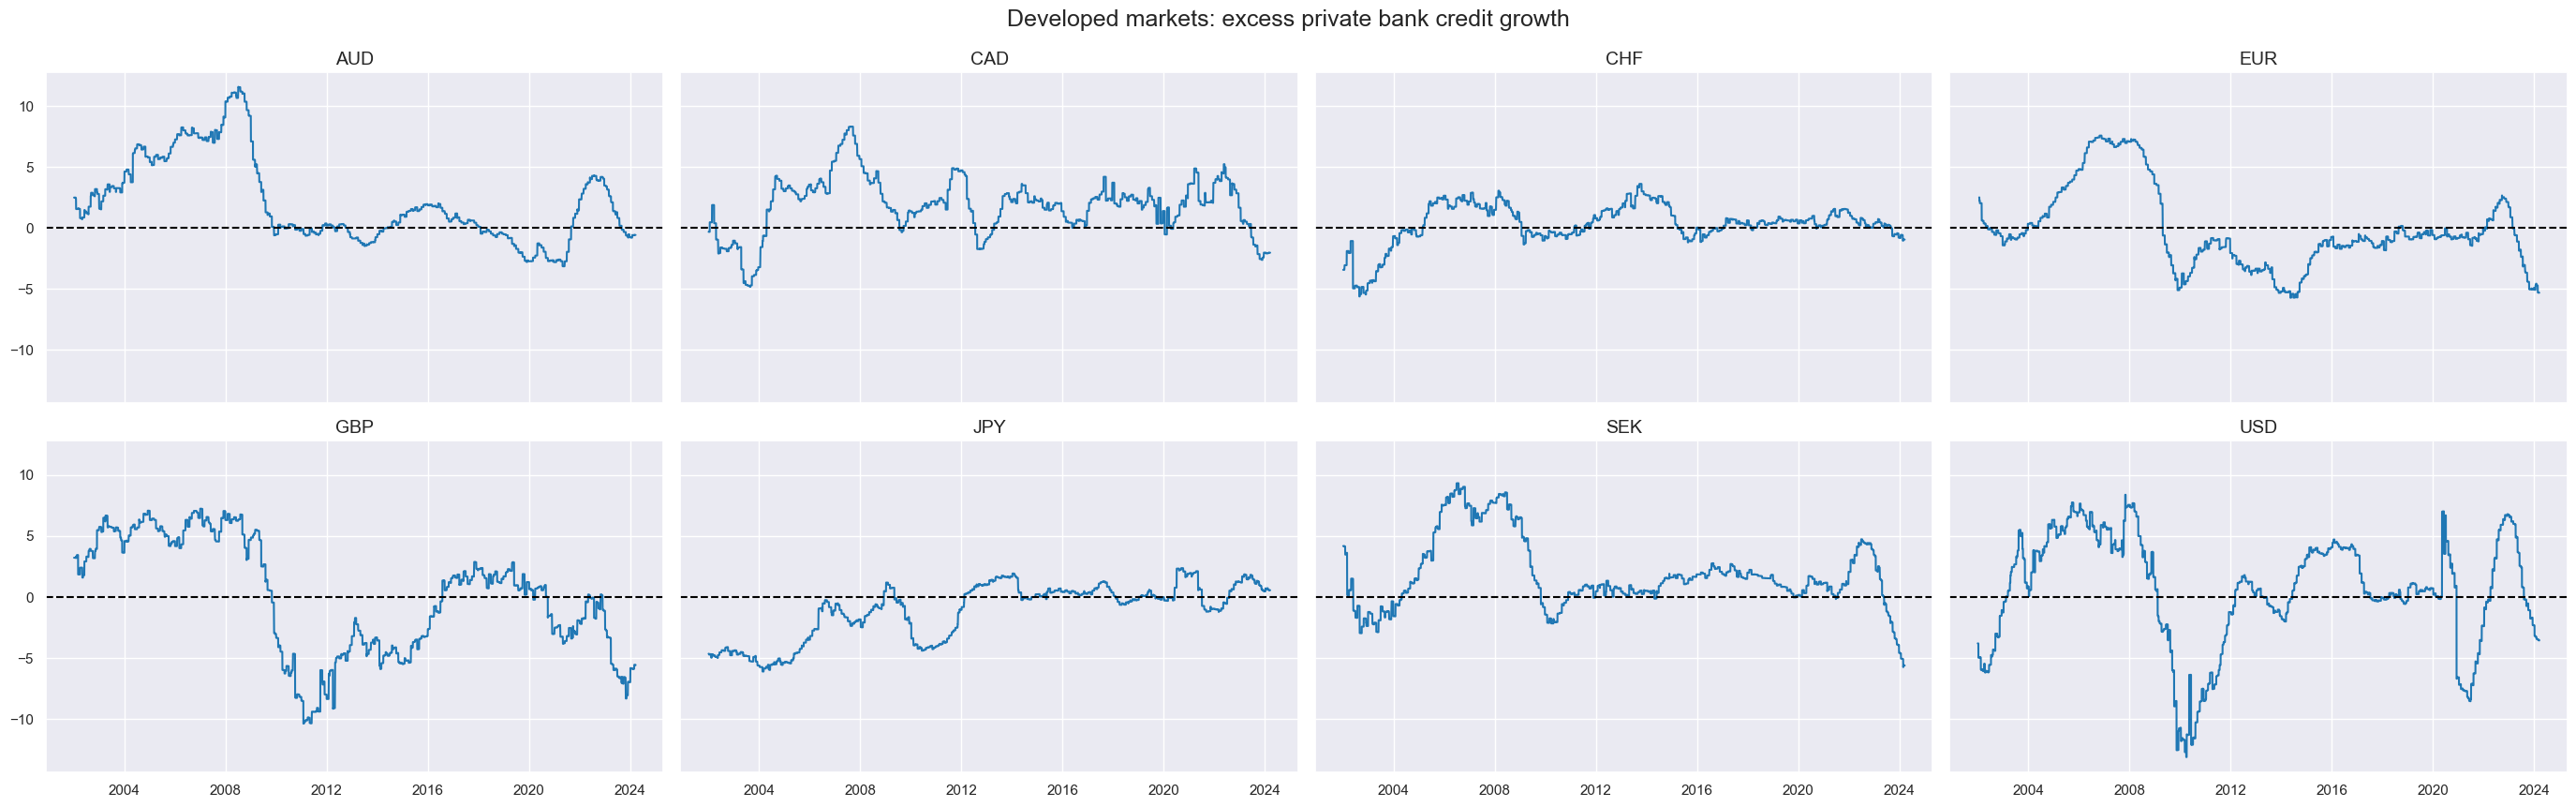

In [13]:
calc_xpc = [
    "XPCREDITBN_SJA_P1M1ML12 = PCREDITBN_SJA_P1M1ML12 - ( INFTEFF_NSA + RGDP_SA_P1Q1QL4_20QMM )"
]
dfa = msp.panel_calculator(dfx, calcs=calc_xpc, cids=cids)
dfx = msm.update_df(dfx, dfa)

xcatx = ["XPCREDITBN_SJA_P1M1ML12"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cids,
    ncol=4,
    cumsum=False,
    start="2002-01-01",
    same_y=True,
    all_xticks=False,
    title="Developed markets: excess private bank credit growth",
)

### Long-long carry

A straightforward 'long-long carry' strategy typically entails the allocation of positions with a 10% volatility target in two distinct asset classes. In the subsequent analysis, we compute a basic equity duration metric by combining the returns of two elements: the Equity Index Future Return for a 10% volatility target ['EQXR_VT10'](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Equity%20index%20future%20returns.php) and the 5-year Maturity Duration Return for a 10% volatility target [`DU05YXR_VT10`](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Equity%20index%20future%20returns.php).

Similarly, the equity duration carry is defined as the summation of two components: the annualized Nominal Equity Index Carry for a 10% volatility target and the annualized Duration Carry for a 10% volatility target. We define excess carry as carry for a 10% vol position minus 2%, as a minimum requirement for carry with such volatility to look attractive.

In summary, this method involves allocating positions with a specified volatility target across asset classes and assessing returns, particularly in the context of equity and duration. The "long-long carry" approach and the subsequent calculations help evaluate and compare performance within a portfolio while considering risk targets.

In [14]:
calc_edc = [
    "EQDUCRY_NSA = EQCRY_VT10 + DU05YCRY_VT10",
    "XEQDUCRY_NSA = EQDUCRY_NSA - 2",
    "EQDUXR_NSA = EQXR_VT10 + DU05YXR_VT10",
]
dfa = msp.panel_calculator(dfx, calcs=calc_edc, cids=cids)
dfx = msm.update_df(dfx, dfa)

With the help of `macrosynergy` package, we estimate historic annualized standard deviations of equity duration measure [`historic_vol()`](https://github.com/macrosynergy/macrosynergy/blob/develop/macrosynergy/panel/historic_vol.py). As lookback method here we choose exponential moving average ('xma'). The new category receives postfix `_ASD`. This function takes a few minutes to run, so please be patient here.

In [15]:
dfa = msp.historic_vol(
    dfx, xcat="EQDUXR_NSA", cids=cids, lback_meth="xma", postfix="_ASD"
)
dfx = msm.update_df(dfx, dfa)

Here, we simply pivot the dataframe containing the estimated historic annualized standard deviations of equity duration measure to wide format, then we resample the dataframe using business month-end frequency ("BM"). For each resampled period, the last value is taken. The resulting resampled DataFrame is reindexed to match the original index of `dft`. Forward-filling missing values in the DataFrame propagates the last valid value forward. Then, the data is shifted by one-time step, effectively moving all values one month forward in time. The dataframe is then transformed back into a long format, and the resampled and shifted category receives the name "EQDUXR_NSA_ASDML1", which is then added to the main DataFrame `dfx`

In [16]:
dft = dfa.pivot(index="real_date", columns="cid", values="value")
dftx = dft.resample("BM").last().reindex(dft.index).ffill().shift(1)
dfax = dftx.unstack().reset_index().rename({0: "value"}, axis=1)
dfax["xcat"] = "EQDUXR_NSA_ASDML1"
dfx = msm.update_df(dfx, dfax)

The basis for carry calculation is risk-parity equity duration positions that are calibrated in the same as those underlying the target returns, as explained in the post. Both the equity index future and IRS fixed receiver legs are equalized in terms of expected volatility, and the overall position is calibrated to a 10% annualized volatility target. The carry values for both legs of the position are taken from JPMaQS, and the documentation can be found in the indicator's pages. 

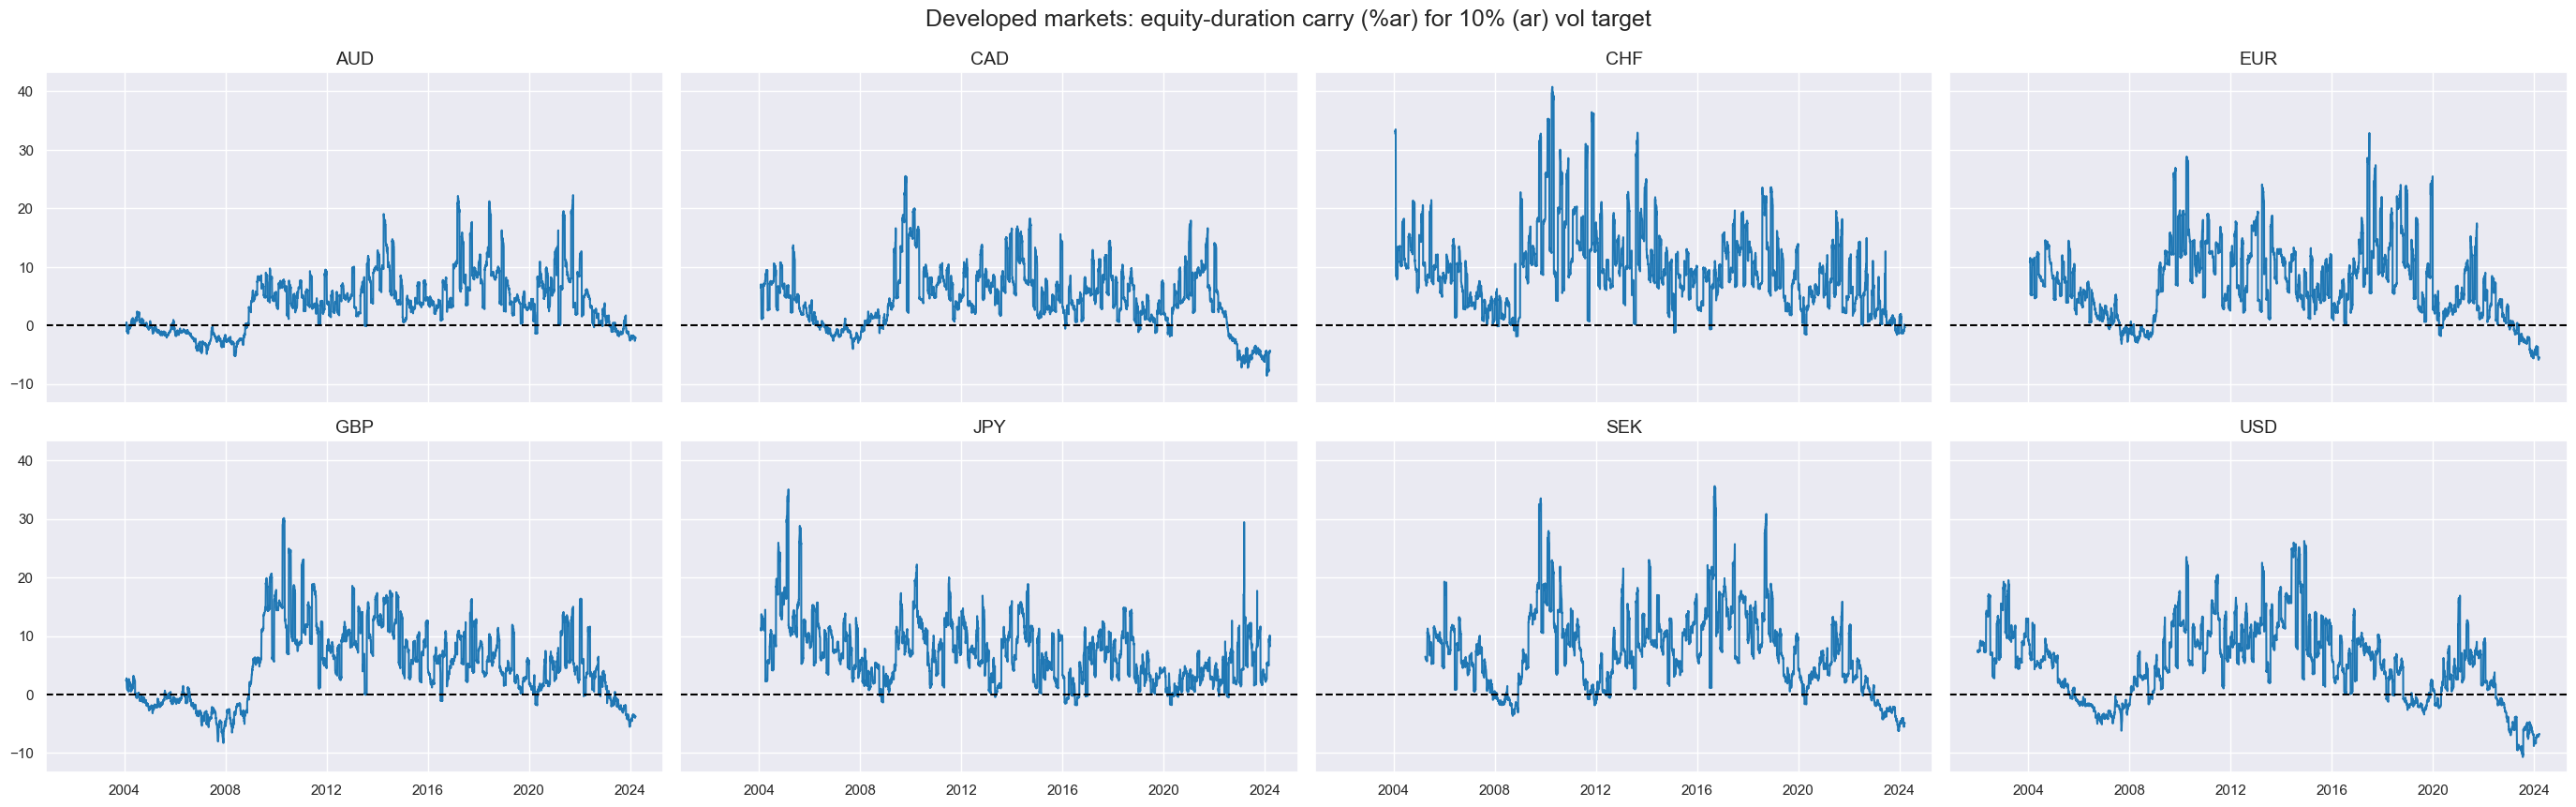

In [17]:
calc_vaj = [
    "EQDUCRY_VT10 = 10 * EQDUCRY_NSA / EQDUXR_NSA_ASDML1",
    "XEQDUCRY_VT10 = EQDUCRY_VT10 - 2",
    "EQDUXR_VT10 = 10 * EQDUXR_NSA / EQDUXR_NSA_ASDML1",
]
dfa = msp.panel_calculator(dfx, calcs=calc_vaj, cids=cids)
dfx = msm.update_df(dfx, dfa)

xcatx = ["XEQDUCRY_VT10"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cids,
    ncol=4,
    cumsum=False,
    start="2002-01-01",
    same_y=True,
    all_xticks=False,
    title="Developed markets: equity-duration carry (%ar) for 10% (ar) vol target",
)

### Composite features

#### Unbiased composites

Here, we rename quarterly employment growth for the convenience of subsequent transformations. This is done for CHF and EUR areas, which release data on a quarterly basis, not on a monthly as in other countries. This has been explained in the first section of this notebook. 

In [18]:
dfx["xcat"] = dfx["xcat"].str.replace("EMPL_NSA_P1Q1QL4", "EMPL_NSA_P1M1ML12_3MMA")

We use the long-term (in-sample) country-specific medians of employment growth as proxy for a neutral and define excess employment growth as difference between respective [employment growth indicator](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Labor%20market%20dynamics.php?highlight=employment) and its median. The new indicator receives the name `XEMPL_NSA_P1M1ML12_3MMA`

In [19]:
dfxx = dfx[dfx["xcat"] == "EMPL_NSA_P1M1ML12_3MMA"]
dfxt = dfxx.pivot(index="real_date", columns="cid", values="value")
dfat = dfxt.sub(
    dfxt.median(axis=0), axis=1
)  # excess employment growth through median subtraction
dfa = dfat.unstack().reset_index().rename({0: "value"}, axis="columns")
dfa["xcat"] = "XEMPL_NSA_P1M1ML12_3MMA"
dfx = msm.update_df(dfx, dfa)

Both excess employment growth `XEMPL_NSA_P1M1ML12_3MMA` defined in the cell above and [`UNEMPLRATE_SA_3MMAv5YMM`](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Labor%20market%20tightness.php?highlight=unemplrate_sa) (Unemployment rate, seasonally adjusted: 3-month moving average minus the 5-year moving average) are z-scored on a panel basis to a maximum value of 2.5 standard deviations and out-of-sample so that they can be added up to a composite measure.

In [20]:
xcats_lab = [
    "XEMPL_NSA_P1M1ML12_3MMA",
    "UNEMPLRATE_SA_3MMAv5YMM",
]

for xcat_sel in xcats_lab:
    dfa = msp.make_zn_scores(
        dfx,
        xcat=xcat_sel,
        cids=cids,
        start="2000-01-01",
        sequential=True,
        min_obs=522,  # oos scaling after 2 years of panel data
        neutral="zero",
        pan_weight=1,  # panel basis means, no consideration of country-specific SDs
        thresh=2.5,  # Maximum score is 2.5 SDs to de-emphasize extreme values
        postfix="ZN",
    )
    dfx = msm.update_df(dfx, dfa)

The composite labor market tightness score `LABTIGHT_CS` is the average of the two labor market z-scores (negative of `UNEMPLRATE_SA_3MMAv5YMMZN` and `XEMPL_NSA_P1M1ML12_3MMAZN`). It shows pronounced cyclical fluctuations and little short-term volatility when compared to standard output-based business cycles or overheating indicators.

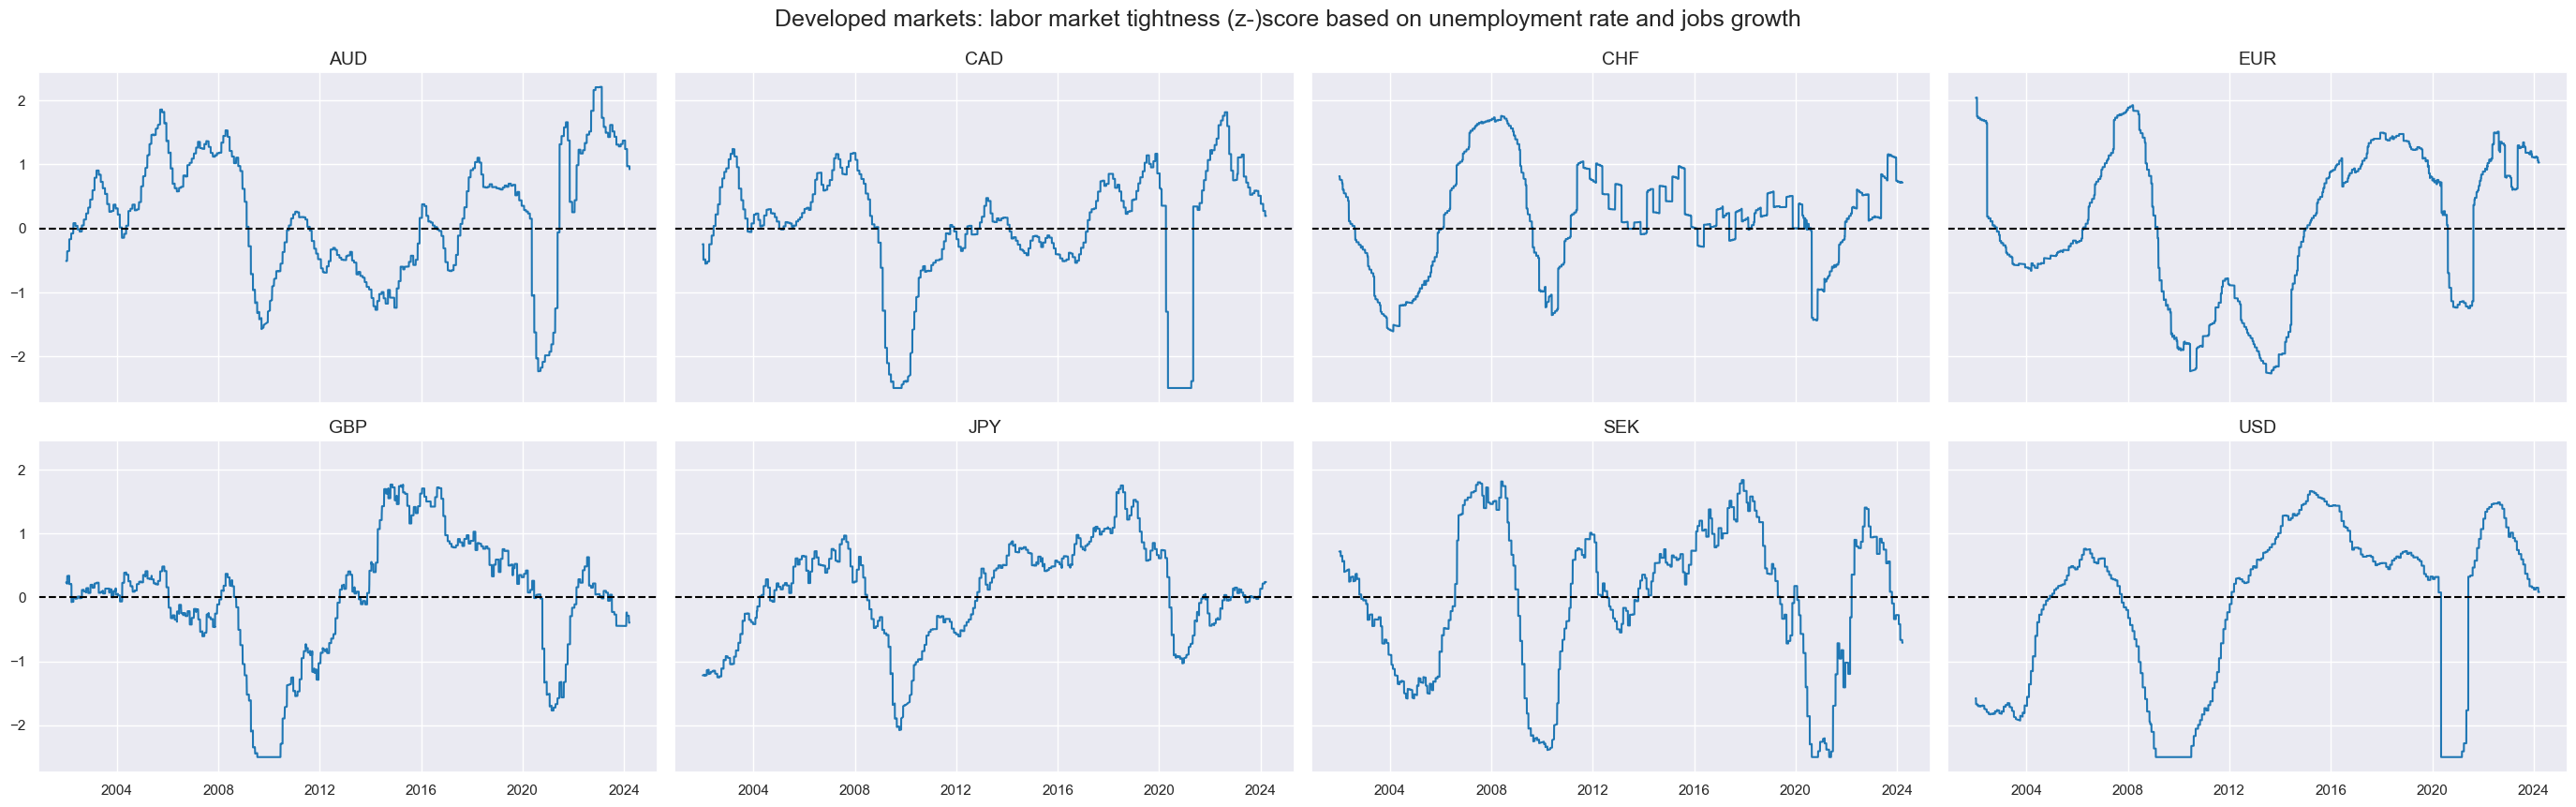

In [21]:
calcs = [
    """
    LABTIGHT_CS = 
    ( XEMPL_NSA_P1M1ML12_3MMAZN - UNEMPLRATE_SA_3MMAv5YMMZN ) / 2
    """,
]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids)
dfx = msm.update_df(dfx, dfa)

xcatx = ["LABTIGHT_CS"]


msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cids,
    ncol=4,
    cumsum=False,
    start="2002-01-01",
    same_y=True,
    all_xticks=False,
    title="Developed markets: labor market tightness (z-)score based on unemployment rate and jobs growth",
)

##### Composite excess macro trend score

A composite overheating score is calculated in a simple (not optimized) way. All four sectoral overheating metrics are z-scored (standardized by out-of-sample panel standard deviations) around their natural zero values and with a cap of 2.5. The GDP growth trend is taken straight from JPMaQS; the other indicators are derived in the previous section based on JPMaQS indicators: 
- real-time GDP growth trend estimate vs 5-year moving average `INTRGDPv5Y_NSA_P1M1ML12_3MMA`,
- the composite labor market tightness score `LABTIGHT_CS`, 
- excess CPI trend, %6m/6m, saar, real-time jump-adjusted,  `XCPIH_SJA_P6M6ML6AR`, and 
- excess private bank credit growth `XPCREDITBN_SJA_P1M1ML12`

In [22]:
xcats_ecs = [
    "INTRGDPv5Y_NSA_P1M1ML12_3MMA",
    "LABTIGHT_CS",
    "XCPIH_SJA_P6M6ML6AR",
    "XPCREDITBN_SJA_P1M1ML12",
]

for xcat_sel in xcats_ecs:
    dfa = msp.make_zn_scores(
        dfx,
        xcat=xcat_sel,
        cids=cids,
        start="2000-01-01",
        sequential=True,
        min_obs=522,  # oos scaling after 2 years of panel data
        neutral="zero",
        pan_weight=1,  # panel basis means, no consideration of country-specific SDs
        thresh=2.5,  # Maximum score is 2.5 SDs to de-emphasize extreme values
        postfix="ZN",
    )
    dfx = msm.update_df(dfx, dfa)

The z-scores are averaged: there is no claim that this is the best way to aggregate overheating performance, but the method’s simplicity makes it suitable for a proof of concept, i.e., a test if a simple overheating score has predicted equity-duration risk-parity returns. The overheating z-score based on growth, labor, prices, and credit receives the name `OVERHEAT_CS`

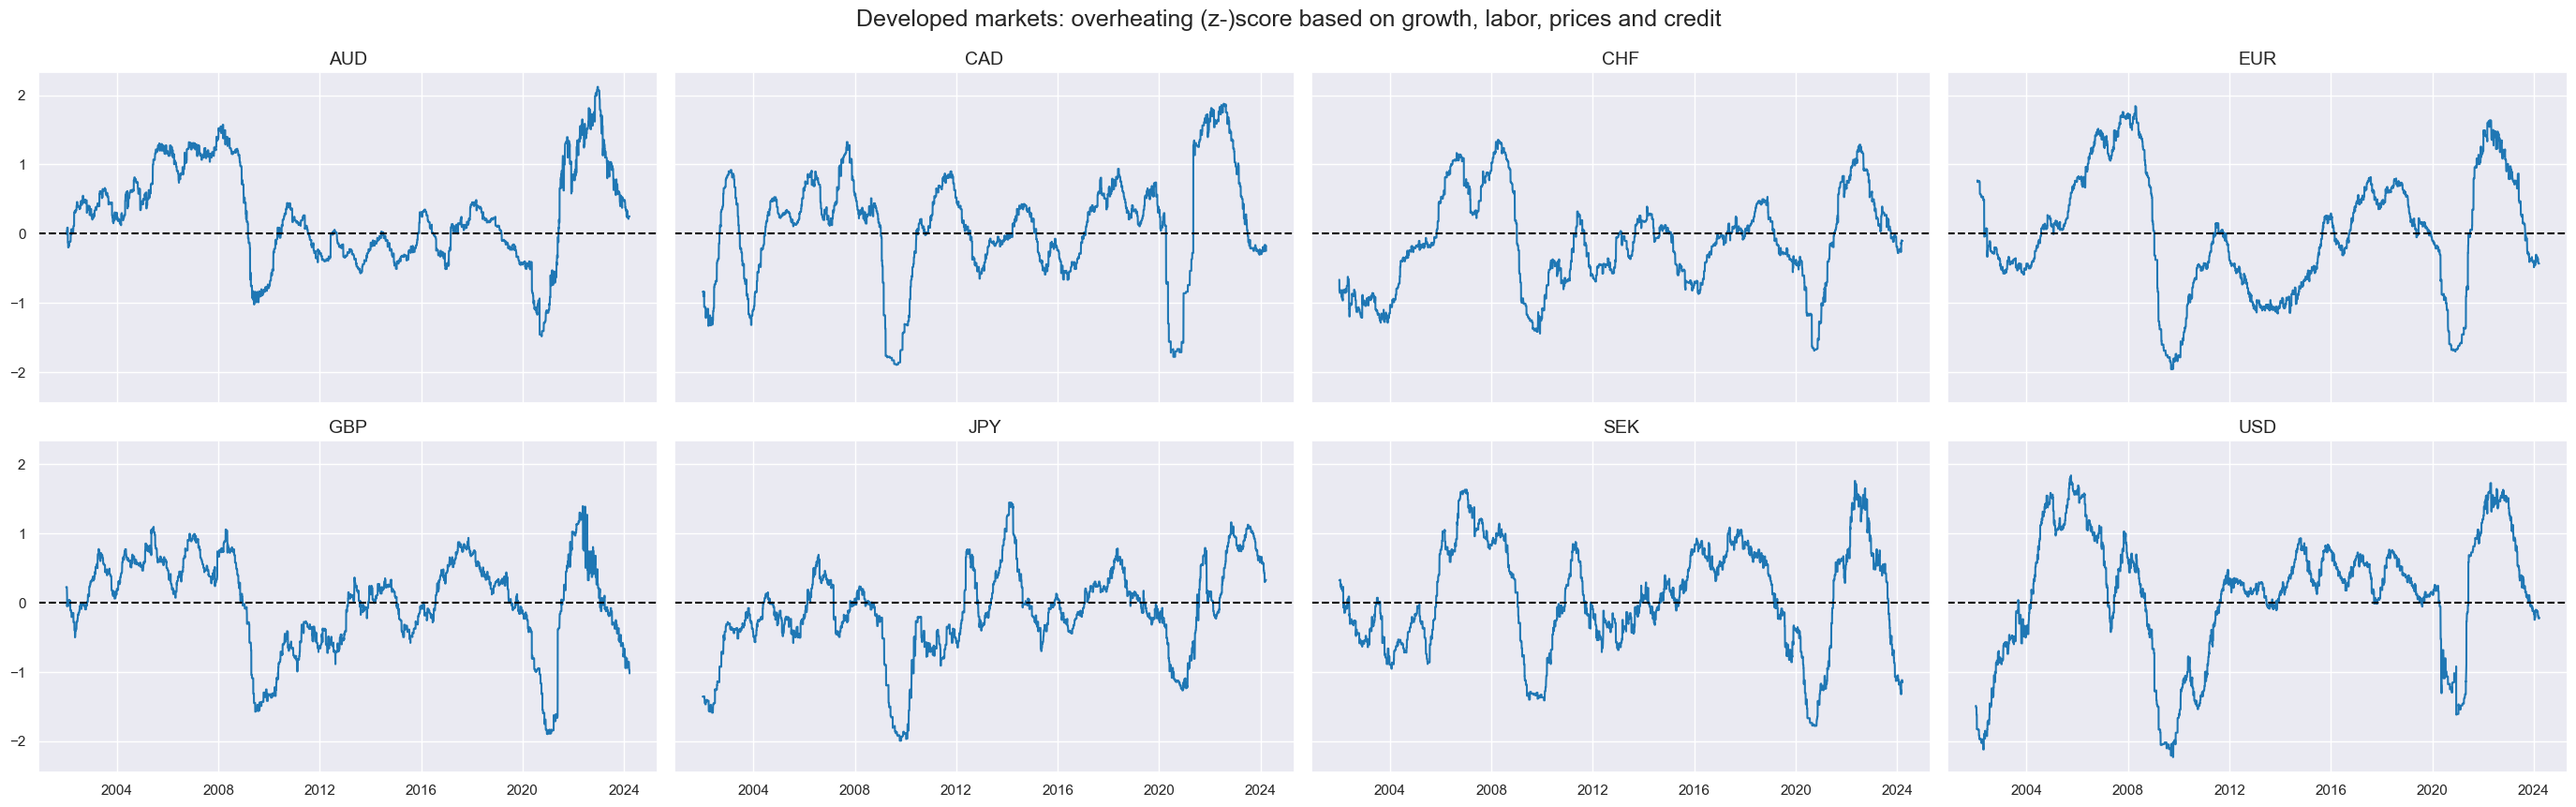

In [23]:
calcs = [
    """
    OVERHEAT_CS = 
    ( INTRGDPv5Y_NSA_P1M1ML12_3MMAZN + LABTIGHT_CSZN  + XCPIH_SJA_P6M6ML6ARZN + XPCREDITBN_SJA_P1M1ML12ZN ) / 4
    """,
]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids)
dfx = msm.update_df(dfx, dfa)

xcatx = ["OVERHEAT_CS"]


msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cids,
    ncol=4,
    cumsum=False,
    start="2002-01-01",
    same_y=True,
    all_xticks=False,
    title="Developed markets: overheating (z-)score based on growth, labor, prices and credit",
)

To combine indicators for later analysis, we z-score again the following indicators: 
- overheating z-score based on growth, labor, prices, and credit `OVERHEAT_CS`, 
- the excess equity duration carry `XEQDUCRY_NSA`, and 
- the calibrated carry `XEQDUCRY_VT10`

In [24]:
xcats_ocr = [
    "OVERHEAT_CS",
    "XEQDUCRY_NSA",
    "XEQDUCRY_VT10",
]

for xcat_sel in xcats_ocr:
    dfa = msp.make_zn_scores(
        dfx,
        xcat=xcat_sel,
        cids=cids,
        start="2000-01-01",
        sequential=True,
        min_obs=522,  # oos scaling after 2 years of panel data
        neutral="zero",
        pan_weight=1,  # panel basis means, no consideration of country-specific SDs
        thresh=2.5,  # Maximum score is 2.5 SDs to de-emphasize extreme values
        postfix="ZN",
    )
    dfx = msm.update_df(dfx, dfa)

To combine these indicators into a single carry-overheating score, we average the carry z-score (`XEQDUCRY_NSAZN`) and the negative of the overheating z-score (`- OVERHEAT_CSZN`). A similar calculation is done for calibrated carry-overheating score:

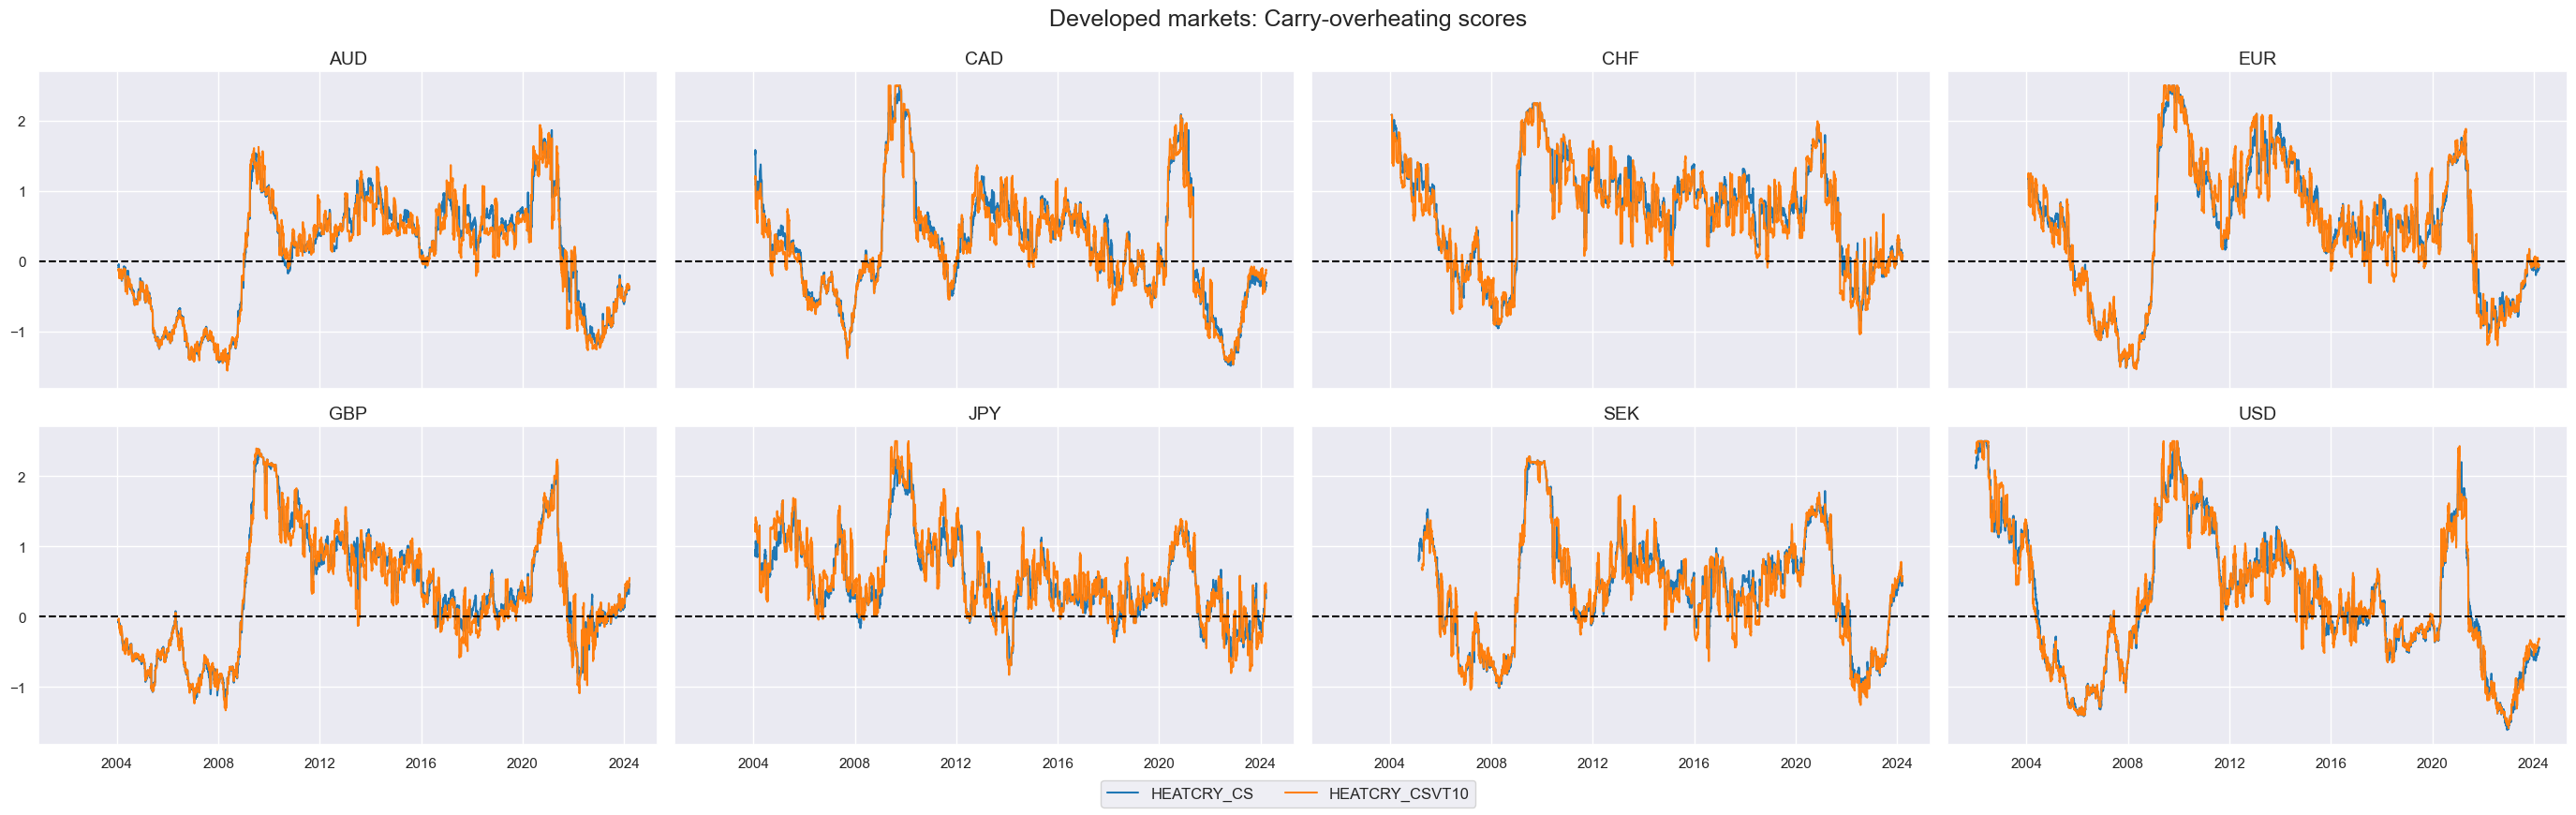

In [25]:
calcs = [
    "HEATCRY_CS = ( - OVERHEAT_CSZN + XEQDUCRY_NSAZN ) / 2",
    "HEATCRY_CSVT10 = ( - OVERHEAT_CSZN + XEQDUCRY_VT10ZN ) / 2",
]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids)
dfx = msm.update_df(dfx, dfa)

xcatx = ["HEATCRY_CS", "HEATCRY_CSVT10"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cids,
    ncol=4,
    cumsum=False,
    start="2002-01-01",
    same_y=True,
    all_xticks=False,
    title="Developed markets: Carry-overheating scores",
)

#### Biased overheating composites

To create long-biased indicators, we will use the following formula: subtract one (standard deviation) from the corresponding score ("M1" at the end of the indicator name indicates "minus one"). This means that in the absence of significant excess macro trends, positions will be equal to the constant long-long. In case of overheating scores in excess of 1 standard deviation, positions will be negative, and in case of negative overheating scores, positions will be larger than for the standard long-long. The long bias of the managed equity-duration parity strategy was set arbitrarily to a unit standard deviation of the overlay signal. It is possible to vary it to include personal preference:

- `OVERHEAT_CSZNM1` - long-biased indicator for macro overheating,
- `INTRGDPv5Y_NSA_P1M1ML12_3MMAZNM1` - long-biased indicator for GDP growth,
- `LABTIGHT_CSZNM1` - long-biased indicator for labor market tightness,
- `XCPIH_SJA_P6M6ML6ARZNM1`- long-biased indicator for inflation,
- `XPCREDITBN_SJA_P1M1ML12ZNM1`-   long-biased indicator for private bank credit growth.


In [26]:
calcs = [
    "OVERHEAT_CSZNM1 = OVERHEAT_CSZN - 1",
    "INTRGDPv5Y_NSA_P1M1ML12_3MMAZNM1 = INTRGDPv5Y_NSA_P1M1ML12_3MMAZN - 1",
    "LABTIGHT_CSZNM1 = LABTIGHT_CSZN - 1",
    "XCPIH_SJA_P6M6ML6ARZNM1 = XCPIH_SJA_P6M6ML6ARZN - 1",
    "XPCREDITBN_SJA_P1M1ML12ZNM1 = XPCREDITBN_SJA_P1M1ML12ZN - 1",
]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids)
dfx = msm.update_df(dfx, dfa)

### Targets

Displaying the equity-duration cumulative returns across currency areas, we observe that they have been between 100% and almost 300% across the main eight developed currencies int the last 20 years. And again, using [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) function from the `macrosynergy` package we display this indicator for different cross-sections over time.

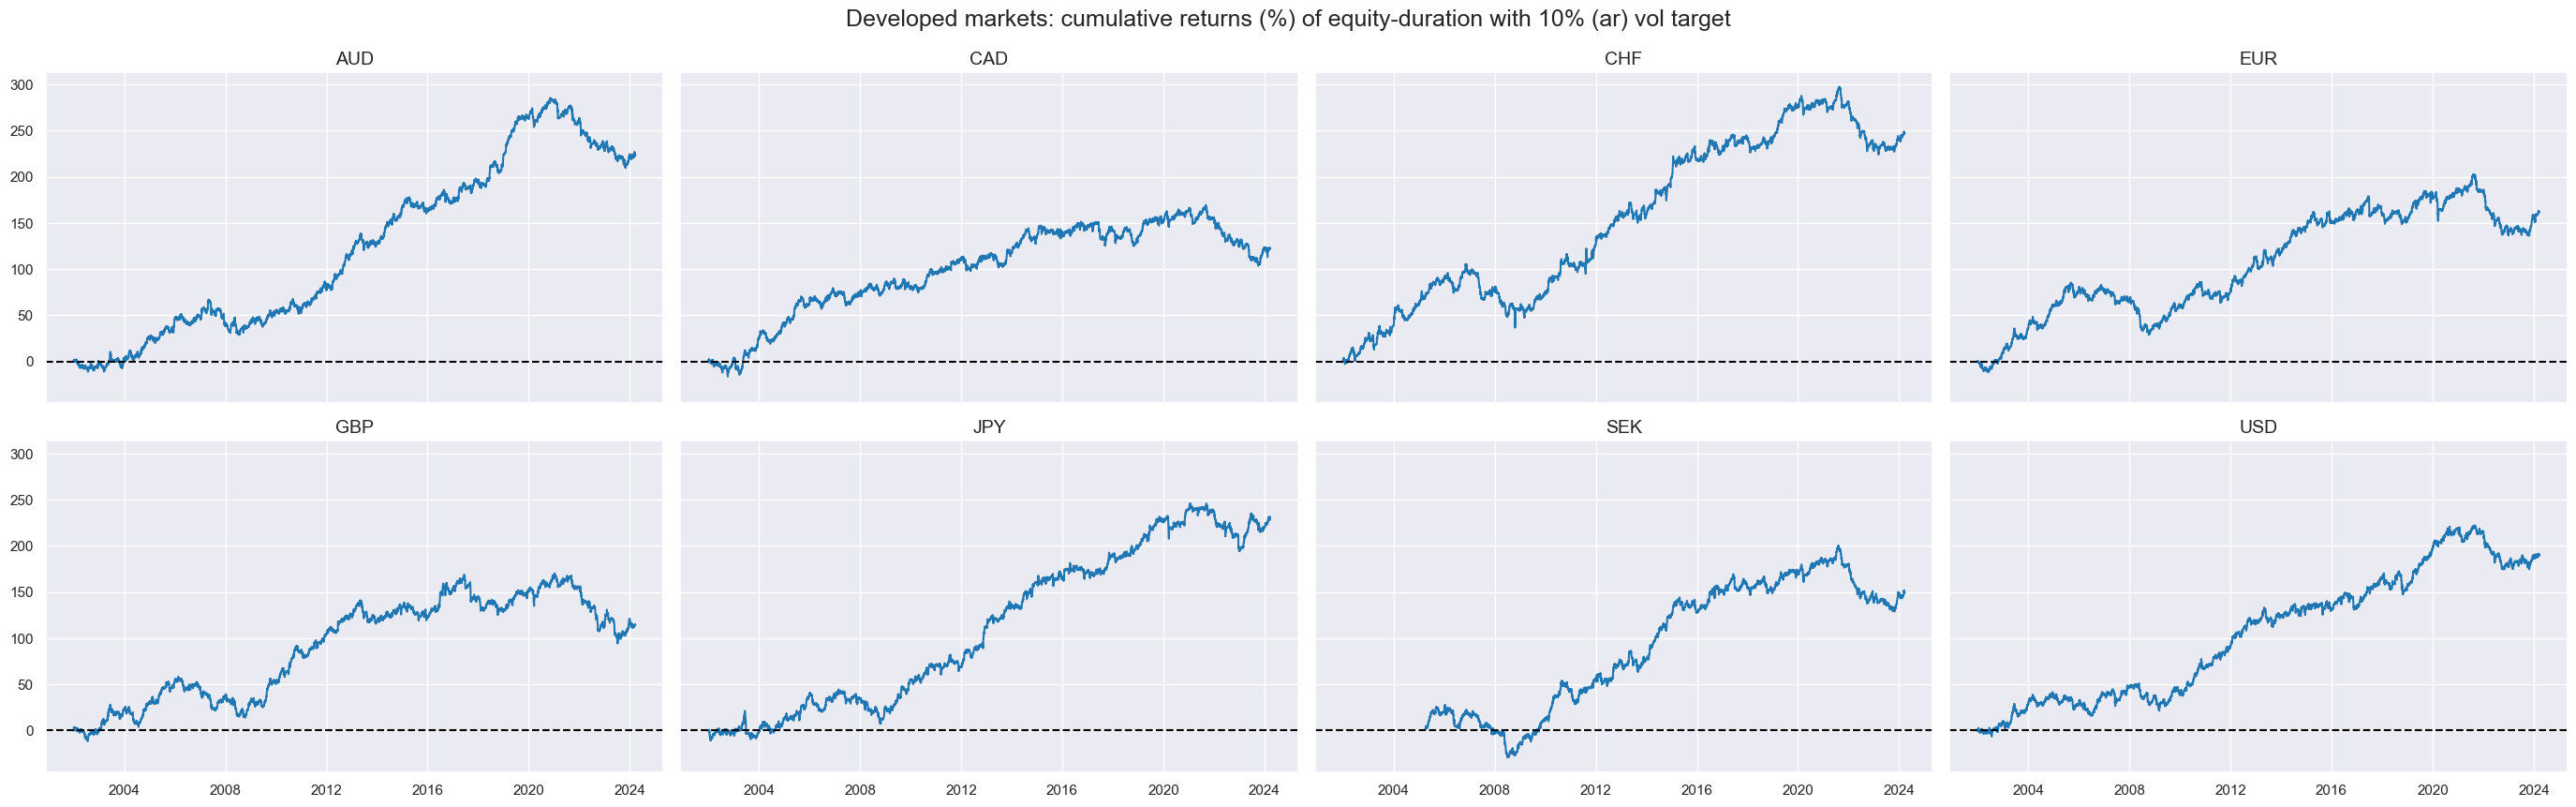

In [27]:
calc_vaj = [
    "EQDUXR_VT10 = 10 * EQDUXR_NSA / EQDUXR_NSA_ASDML1",
]
dfa = msp.panel_calculator(dfx, calcs=calc_vaj, cids=cids)
dfx = msm.update_df(dfx, dfa)

xcatx = ["EQDUXR_VT10"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cids,
    ncol=4,
    cumsum=True,
    start="2002-01-01",
    same_y=True,
    all_xticks=False,
    title="Developed markets: cumulative returns (%) of equity-duration with 10% (ar) vol target",
)

## Value checks

In this part of the analysis, the notebook calculates the naive PnLs (Profit and Loss) for two simple value checks: based on sample periods of 2002 or 2004 for all eight developed markets, we test two basic propositions:

- A simple composite overheating score predicts returns of equity-duration risk parity positions and can be used to manage the standard “constant long-long” exposure (“macro trends overlay”).
- A combination of equity-duration carry and composite overheating score serves as long-short signal for equity-duration risk parity exposure.

The PnLs are calculated based on simple trading strategies that utilize the created indicators as signals (no regression analysis is involved). The strategies involve going long (buying) or short (selling) on equity-duration risk parity positions based purely on the direction of the signals.

To evaluate the performance of these strategies, the notebook computes various metrics and ratios, including:

- Correlation: Measures the relationship between the inflation-based strategy returns and the actual returns. Positive correlations indicate that the strategy moves in the same direction as the market, while negative correlations indicate an opposite movement.

- Accuracy Metrics: These metrics assess the accuracy of inflation-based strategies in predicting market movements. Standard accuracy metrics include accuracy rate, balanced accuracy, precision, etc.

- Performance Ratios: Various performance ratios, such as Sharpe ratio, Sortino ratio, Max draws, etc.

It is important to note that the analysis deliberately disregards transaction costs and risk management considerations. This is done to provide a more straightforward comparison of the strategies' raw performance without the additional complexity introduced by transaction costs and risk management, which can vary based on trading size, institutional rules, and regulations.

The analysis in the post and sample code in the notebook is a proof of concept only, using the simplest design, including only directional index returns.

### Overheating scores as trading signals

For a simple, plausible value check, we first determine the flagship factor, which should be the broadest of most plausible ones, not the one with the best empirical fit. Then, we set a list of plausible rival factors. Then, we set the target returns and the cross sections investigated.

To start the analysis, we define the list of simple overheating indicators as before:
- `OVERHEAT_CS` - macro overheating indicator, z-score. This will be the main indicator.
- `INTRGDPv5Y_NSA_P1M1ML12_3MMAZN` - z-score overheating GDP growth,
- `LABTIGHT_CSZN` - z-score labor market tightness,
- `XCPIH_SJA_P6M6ML6ARZN`- z-score inflation indicator,
- `XPCREDITBN_SJA_P1M1ML12ZN`- z-score private bank credit growth

And the target will be risk-parity equity-duration position, `EQDUXR_VT10`




In [28]:
feats = [
    "OVERHEAT_CS",
    "INTRGDPv5Y_NSA_P1M1ML12_3MMAZN",
    "LABTIGHT_CSZN",
    "XCPIH_SJA_P6M6ML6ARZN",
    "XPCREDITBN_SJA_P1M1ML12ZN",
]

main_feat = feats[0]
target = "EQDUXR_VT10"

Instances of the class `CategoryRelations` of the `macrosynnergy.panel` package collect panels of features and targets in the appropriate form for analysis, including options for frequency conversion, lagging, and outlier trimming.  The `reg_scatter` method of the class displays a correlation scatter of the pooled data or a section thereof.

The plot below indicates a strong negative correlation on an annual basis (of more than 40%) between a simple composite overheating score based on growth, labor market conditions, inflation, and credit growth and concurrent equity duration returns over the past 20 years across all major developed markets.

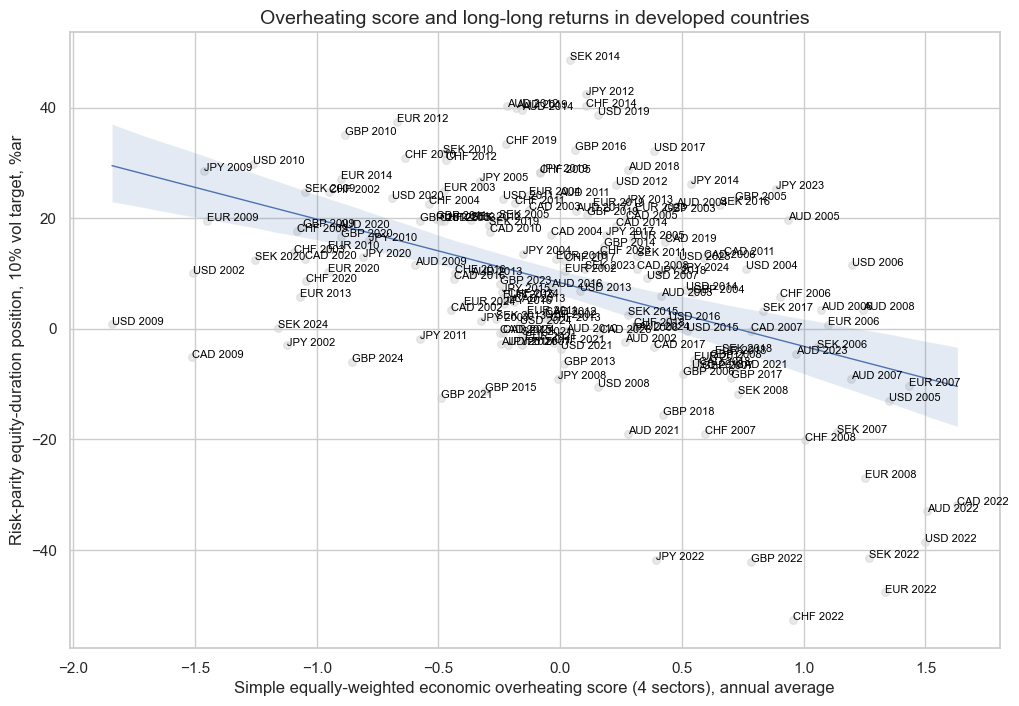

In [29]:
cr_long = msp.CategoryRelations(
    dfx,
    xcats=[main_feat, target],
    cids=cids,
    freq="A",
    lag=0,
    xcat_aggs=["mean", "sum"],
    start="2002-01-01",
    xcat_trims=[None, None],
)
cr_long.reg_scatter(
    labels=True,
    coef_box=None,  # "lower left",
    title="Overheating score and long-long returns in developed countries",
    xlab="Simple equally-weighted economic overheating score (4 sectors), annual average",
    ylab="Risk-parity equity-duration position, 10% vol target, %ar",
)

The same analysis can be done for the other features and on a different frequency basis. The analysis below is based on monthly frequency. We then test the correlation between monthly overheating scores and subsequent monthly risk-parity returns. If markets are not fully information efficient, excess growth, inflation, and so forth should herald low or negative long-long returns. Indeed, overheating has been significantly and negatively related to subsequent risk-parity returns in the overall panel, in every country, and across decades (see chart below).

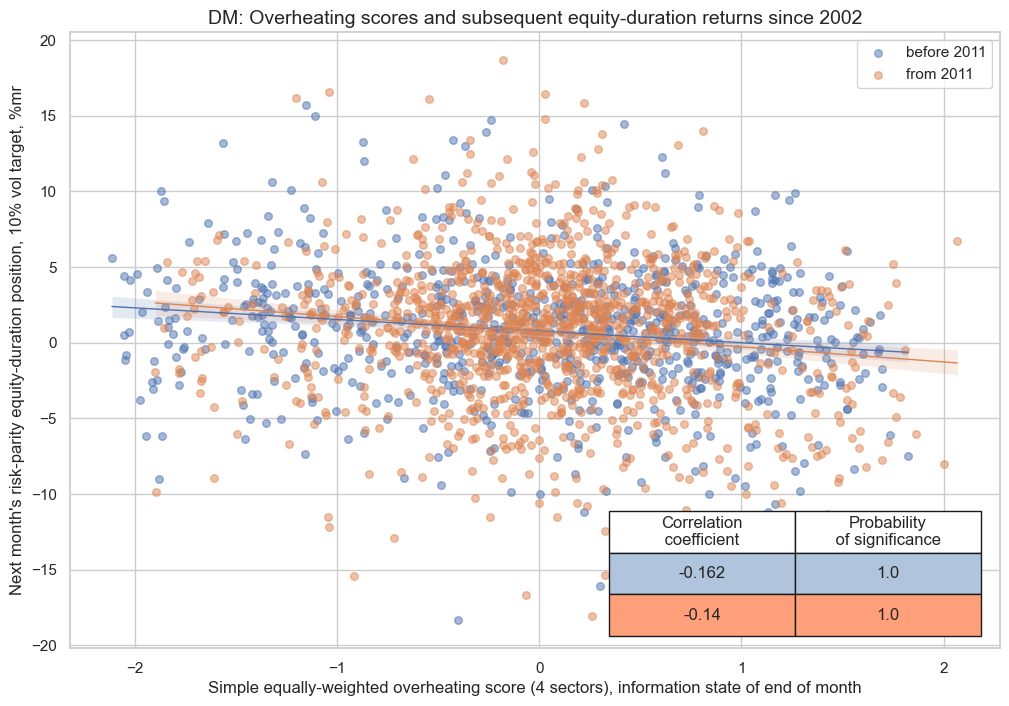

In [30]:
cr = msp.CategoryRelations(
    dfx,
    xcats=[main_feat, target],
    cids=cids,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="2002-01-01",
    xcat_trims=[None, None],
)

cr.reg_scatter(
    labels=False,
    coef_box="lower right",
    separator=2011,
    title="DM: Overheating scores and subsequent equity-duration returns since 2002",
    xlab="Simple equally-weighted overheating score (4 sectors), information state of end of month",
    ylab="Next month's risk-parity equity-duration position, 10% vol target, %mr",
)

Looking at each cross-section separately, we confirm that every cross-section without exceptions displayed a negative correlation:

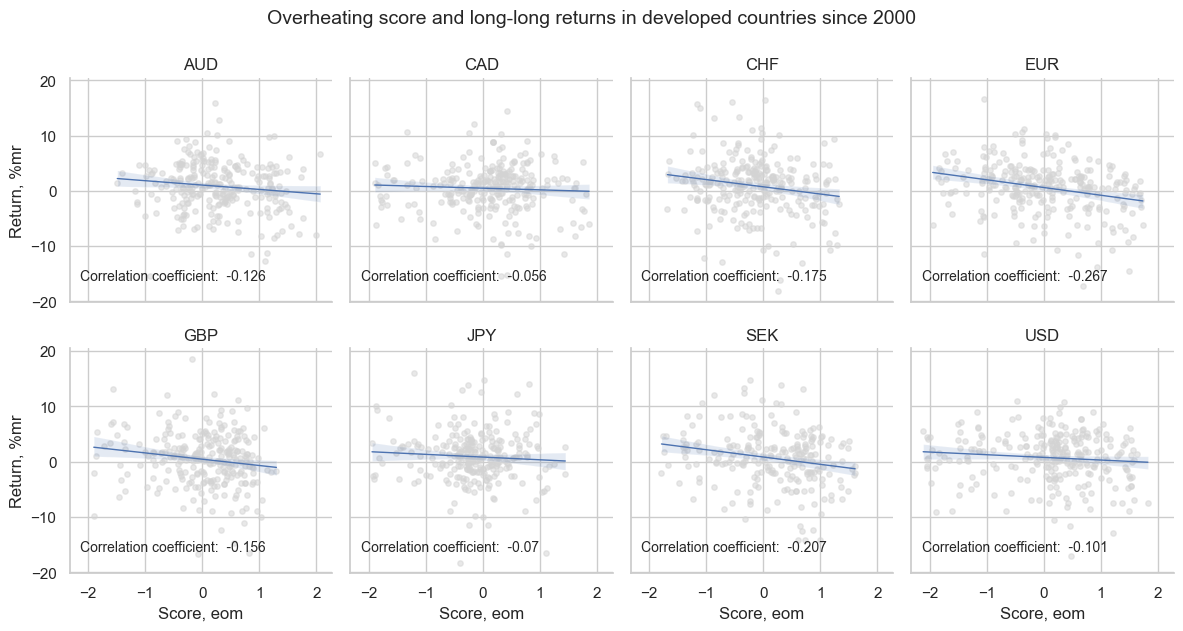

In [31]:
cr.reg_scatter(
    labels=False,
    coef_box="upper left",
    title="Overheating score and long-long returns in developed countries since 2000",
    xlab="Score, eom",
    ylab="Return, %mr",
    separator="cids",
    title_adj=1.05,
)

The [`SignalReturnRelations`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) class of the `macrosynergy.signal` module collects main positioning factor and its key rivals (or constituents), and brings them into the right format by appropriate frequency conversion (which should correspond to the envisaged trading frequency) and whether the signal is supposed to predict the return positively or negatively. Since the relationship between the chosen signal and target is negative, we select the option "sig_neg=True" below:

In [32]:
sigs = [main_feat] + list(set(feats) - set([main_feat]))
srr = mss.SignalReturnRelations(
    dfx,
    cids=cids,
    sigs=sigs,
    sig_neg=[True] * len(sigs),
    rets=target,
    freqs="M",
    start="2000-01-01",
)

The `summary_table()` method of the [`SignalReturnRelations`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) class yields a table with the most important categorical scores (scores that describe the quality of trading factor to predict the direction of the periodic return) as well as parametric and non-parametric correlation statistics.

As a trading signal, overheating scores do not conceptually imply a long bias for risk-parity positions. Indeed, over the past 20 years, they implied a small short bias. Hence, on its own, the overheating score would not have been suitable for extracting the equity and term risk premia. Still, it delivered around 52% accuracy (ratio of correctly predicted monthly return directions) and 52.9% balanced accuracy (average of the ratios of correctly detected positive returns and correctly detected negative returns). This means that the overheating score has meaningfully helped predict market direction.

In [33]:
display(srr.summary_table().astype("float").round(3))

accuracy  bal_accuracy  pos_sigr  pos_retr  pos_prec  \
Panel              0.520         0.528     0.461     0.601     0.632   
Mean years         0.517         0.485     0.470     0.598     0.573   
Positive ratio     0.520         0.480     0.520     0.840     0.800   
Mean cids          0.521         0.530     0.460     0.600     0.633   
Positive ratio     0.750         0.875     0.375     1.000     1.000   

                neg_prec  pearson  pearson_pval  kendall  kendall_pval    auc  
Panel              0.425    0.132         0.000    0.077         0.000  0.529  
Mean years         0.397    0.015         0.431    0.007         0.414  0.493  
Positive ratio     0.160    0.480         0.360    0.560         0.360  0.480  
Mean cids          0.427    0.132         0.167    0.078         0.237  0.530  
Positive ratio     0.000    1.000         0.875    0.750         0.750  0.875

We calculate naïve PnLs based on the following assumptions:
- Positions are taken based on z-scores of the overheating score. The z-scores are winsorized at two standard deviations to mitigate data outliers and to avoid excessive risk-taking in any single market or period.
- Positions are rebalanced monthly with a one-day slippage for trading.
- The long-term volatility of the PnL for positions across all currency areas has been set to 10%.

These are standard procedures that we have been using in previously published proof-of-concept analyses. Note that this PnL is called “naïve” because it does not consider transaction costs and realistic risk management rules.

[`NaivePnl()` class](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#naivepnl) from macrosynergy package is designed to provide a quick and simple overview of a stylized PnL profile of a set of trading signals. 

The related `make_pnl()` method calculates and stores generic PnLs based on a range of signals and their transformations into positions. The positioning options include choice of trading frequency, z-scoring, simple equal-size long-short positions (-1/1) thresholds to prevent outsized positions, and rebalancing slippage.
The generated PnLs are, however, naive insofar as they do not consider trading costs and plausible risk management restrictions. Also, if a volatility scale is set this is done so ex-post, mainly for the benefit of plotting different signals'  PnLs in a single chart.

A complementary method is `make_long_pnl()`, which calculates a "long-only" PnL based on a uniform long position across all markets at all times. This often serves as a benchmark for gauging the benefits of active trading.

In [34]:
start_date = "2002-01-01"
sigs = feats

naive_pnl = msn.NaivePnL(
    dfx,
    ret=target,
    sigs=sigs,
    cids=cids,
    start=start_date,
    bms=["USD_EQXR_NSA"],
)

for sig in sigs:
    naive_pnl.make_pnl(
        sig,
        sig_neg=True,
        sig_op="zn_score_pan",
        thresh=2,
        rebal_freq="monthly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "_PZN",
    )

naive_pnl.make_long_pnl(vol_scale=10, label="Constant long-long")

The PnLs are plotted using `.plot_pnls()` method of the [`NaivePnl()` class](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#naivepnl). These plots mainly inform on seasonality and stability of value generation under the assumption of negligible transaction costs.

The chart below illustrates that value generation of the overheating score has naturally focussed on periods when the economy was significantly overheating or underperforming, such as the great financial crisis and the COVID pandemic (see chart below). Notwithstanding its pronounced seasonality, the overheating-based PnL has produced roughly the same Sharpe ratio as the constant long-long portfolio but without any long bias and any correlation to market benchmarks.

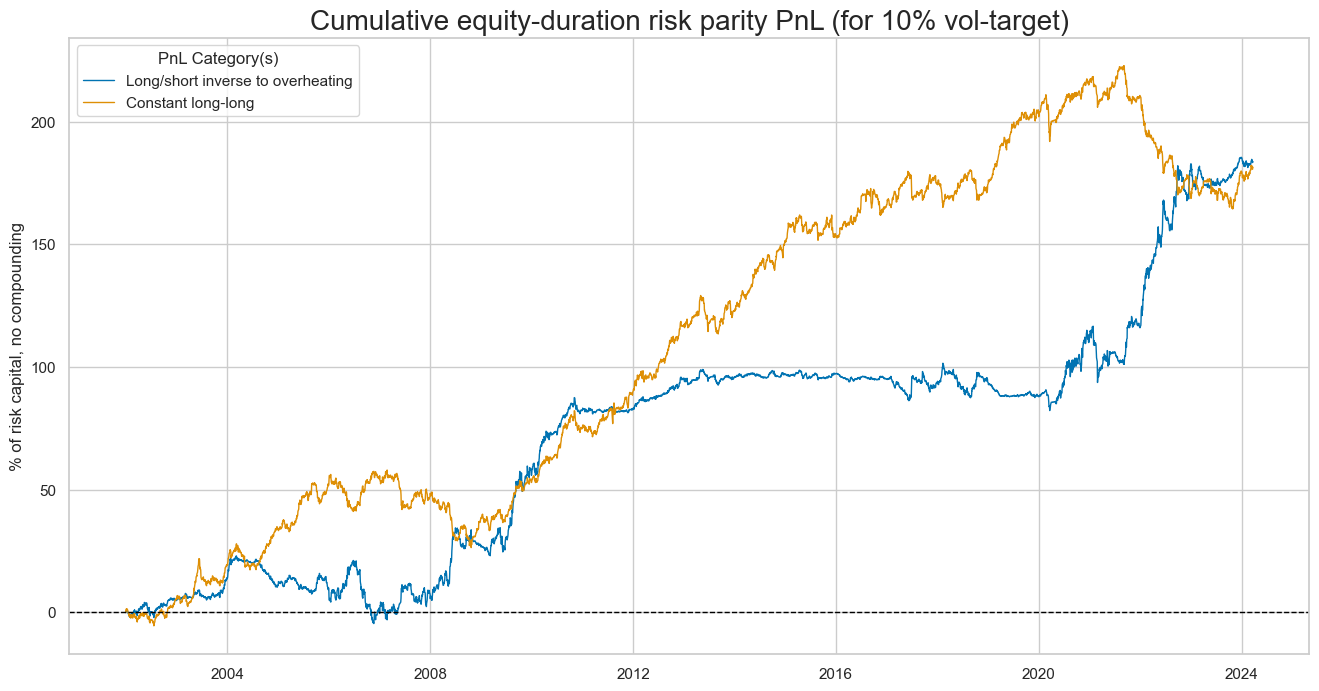

In [35]:
pnls = [sigs[0] + "_PZN"] + ["Constant long-long"]
dict_labels={"OVERHEAT_CS_PZN": "Long/short inverse to overheating", "Constant long-long": "Constant long-long"}   


naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start_date,
    title="Cumulative equity-duration risk parity PnL (for 10% vol-target)",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

The method [`evaluate_pnls()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#naivepnl) returns a small dataframe of key PnL statistics including annualized returns, sharpe, and sortino ratios as well as the max drawdowns.  

In [36]:
pnls = [sigs[0] + "_PZN"] + ["Constant long-long"]
df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start_date,
)

In [37]:
display(df_eval)

xcat                Constant long-long OVERHEAT_CS_PZN
Return (pct ar)               8.164805        8.270122
St. Dev. (pct ar)                 10.0            10.0
Sharpe Ratio                   0.81648        0.827012
Sortino Ratio                 1.133323        1.265823
Max 21-day draw             -18.623478      -20.104724
Max 6-month draw            -31.049742      -22.961272
USD_EQXR_NSA correl           0.365098        -0.02742
Traded Months                      267             267

### Macro overlay of the long-long portfolio

To test the proposition of a “macro overlay” of the long-long portfolio, we set the normal position value for each country to 1 and then subtract the overheating z-score. This means that in the absence of significant excess macro trends, positions will be equal to the constant long-long, in case of overheating scores in excess of one standard deviation, positions will be negative, and in case of negative overheating scores, positions will be larger than for the standard long-long. For a simple plausible value check proposed positioning factors and their key components we first determine the flagship factor `OVERHEAT_CSZNM1` Then we set a list of plausible rival factors (the components of `OVERHEAT_CSZNM1` in this case). And the target remains risk-parity equity-duration position, `EQDUXR_VT10`.

In [38]:
feats = [
    "OVERHEAT_CSZNM1",
    "INTRGDPv5Y_NSA_P1M1ML12_3MMAZNM1",
    "LABTIGHT_CSZNM1",
    "XCPIH_SJA_P6M6ML6ARZNM1",
    "XPCREDITBN_SJA_P1M1ML12ZNM1",
]

main_feat = feats[0]
target = "EQDUXR_VT10"

Instances of the class `CategoryRelations` of the `macrosynnergy.panel` package collect panels of features and targets in the appropriate form for analysis, including options for frequency conversion, lagging, and outlier trimming.  The `reg_scatter` method of the class displays a correlation scatter of the pooled data or a section thereof.

In [39]:
sigs = [main_feat] + list(set(feats) - set([main_feat]))
srr = mss.SignalReturnRelations(
    dfx,
    cids=cids,
    sigs=sigs,
    sig_neg=[True] * len(sigs),
    rets=target,
    freqs="M",
    start="2000-01-01",
)

The monthly accuracy of the macro overlay signal has been near 60%, and even the balanced accuracy, which is not affected by the long bias, has been above 55%.

In [40]:
display(srr.summary_table().astype("float").round(3))

accuracy  bal_accuracy  pos_sigr  pos_retr  pos_prec  \
Panel              0.589         0.549     0.766     0.601     0.624   
Mean years         0.583         0.508     0.768     0.598     0.596   
Positive ratio     0.800         0.520     0.800     0.840     0.800   
Mean cids          0.589         0.550     0.763     0.600     0.625   
Positive ratio     1.000         0.750     1.000     1.000     1.000   

                neg_prec  pearson  pearson_pval  kendall  kendall_pval    auc  
Panel              0.475    0.133         0.000    0.077         0.000  0.537  
Mean years         0.342    0.016         0.426    0.008         0.416  0.494  
Positive ratio     0.160    0.480         0.400    0.560         0.400  0.400  
Mean cids          0.476    0.133         0.164    0.077         0.238  0.538  
Positive ratio     0.250    1.000         0.875    0.750         0.750  0.750

Furthermore, accuracies have been above 50% in all countries, and only the balanced accuracy in Canada and Japan has been slightly below that threshold.

In [41]:
display(srr.cross_section_table().astype("float").round(3))

accuracy  bal_accuracy  pos_sigr  pos_retr  pos_prec  neg_prec  \
Panel        0.589         0.549     0.766     0.601     0.624     0.475   
Mean         0.589         0.550     0.763     0.600     0.625     0.476   
PosRatio     1.000         0.750     1.000     1.000     1.000     0.250   
AUD          0.572         0.542     0.720     0.587     0.610     0.474   
CAD          0.545         0.495     0.759     0.593     0.591     0.400   
CHF          0.655         0.631     0.838     0.624     0.667     0.596   
EUR          0.609         0.567     0.722     0.624     0.661     0.473   
GBP          0.589         0.562     0.825     0.582     0.604     0.521   
JPY          0.562         0.485     0.893     0.586     0.583     0.387   
SEK          0.575         0.556     0.654     0.579     0.617     0.494   
USD          0.603         0.564     0.693     0.628     0.667     0.461   

          pearson  pearson_pval  kendall  kendall_pval    auc  
Panel       0.133         0.000    0.077         0.000  0.537  
Mean        0.133         0.164    0.077         0.238  0.538  
PosRatio    1.000         0.875    0.750         0.750  0.750  
AUD         0.120         0.048    0.073         0.074  0.535  
CAD         0.043         0.463   -0.015         0.703  0.497  
CHF         0.149         0.011    0.085         0.031  0.576  
EUR         0.271         0.000    0.177         0.000  0.558  
GBP         0.162         0.007    0.107         0.008  0.537  
JPY         0.028         0.632   -0.003         0.944  0.494  
SEK         0.205         0.002    0.137         0.002  0.552  
USD         0.085         0.148    0.058         0.139  0.558

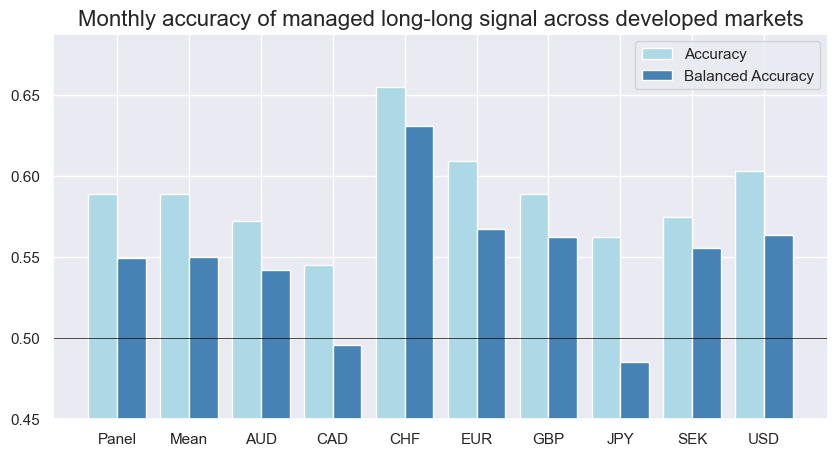

In [42]:
srr.accuracy_bars(
    type="cross_section",
    title="Monthly accuracy of managed long-long signal across developed markets",
    size=(10, 5),
    legend_pos="best",
)

As in the section above, we use the `NaivePnL` class of the `macrosynergy.signal` module as the basis for calculating simple stylized PnLs for various signals considering correlation benchmarks.

The related `make_pnl()` method calculates and stores generic PnLs based on a range of signals and their transformations into positions. The positioning options include choice of trading frequency, z-scoring, simple equal-size long-short positions (-1/1) thresholds to prevent outsized positions, and rebalancing slippage.
The generated PnLs are, however, naive insofar as they do not consider trading costs and plausible risk management restrictions. Also, if a volatility scale is set this is done so ex-post, mainly for the benefit of plotting different signals' PnLs in a single chart.

A complementary method is `make_long_pnl()`, which calculates a "long-only" PnL based on a uniform long position across all markets at all times. This often serves as a benchmark for gauging the benefits of active trading.

In [43]:
start_date = "2002-01-01"
sigs = feats

naive_pnl = msn.NaivePnL(
    dfx,
    ret=target,
    sigs=sigs,
    cids=cids,
    start=start_date,
    bms=["USD_EQXR_NSA"],
)

for sig in sigs:
    naive_pnl.make_pnl(
        sig,
        sig_neg=True,
        sig_op="zn_score_pan",
        thresh=2,
        rebal_freq="monthly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "_PZN",
    )

naive_pnl.make_long_pnl(vol_scale=10, label="Constant long-long")

Simple cumulative PnLs in the class instance can be plotted with the `plot_pnls()` method. They mainly inform on seasonality and stability of value generation under the assumption of negligible transaction costs. As expected, the long-long managed strategy is much closer to long only strategy and outperforms the previous, not managed strategy. 

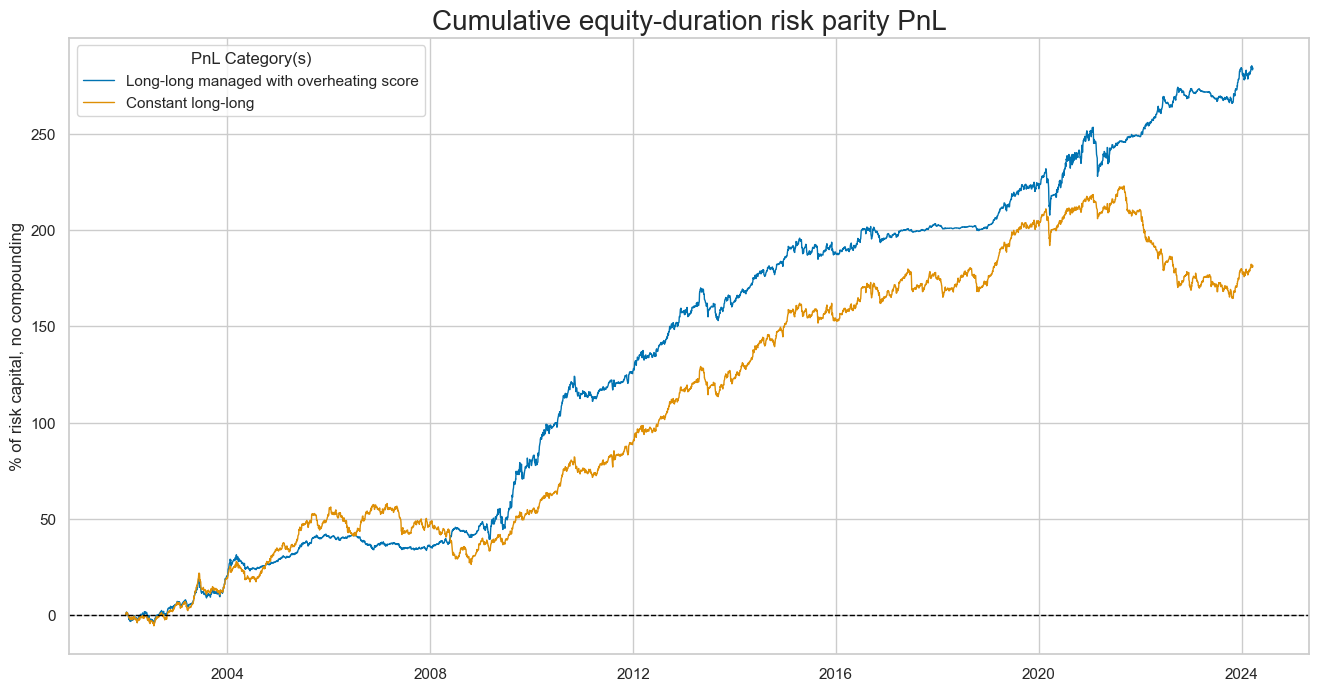

In [44]:
pnls = [sigs[0] + "_PZN"] + ["Constant long-long"]
dict_labels={"OVERHEAT_CSZNM1_PZN": "Long-long managed with overheating score", "Constant long-long": "Constant long-long"} 

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start_date,
    title="Cumulative equity-duration risk parity PnL",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

In [45]:
pnls = [sigs[0] + "_PZN"] + ["Constant long-long"]
df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start_date,
)

In [46]:
display(df_eval)

xcat                Constant long-long OVERHEAT_CSZNM1_PZN
Return (pct ar)               8.164805           12.786892
St. Dev. (pct ar)                 10.0                10.0
Sharpe Ratio                   0.81648            1.278689
Sortino Ratio                 1.133323            1.859708
Max 21-day draw             -18.623478           -23.55514
Max 6-month draw            -31.049742          -15.535498
USD_EQXR_NSA correl           0.365098             0.25126
Traded Months                      267                 267

### Carry overheating strategy

As a reminder, the proposed signal here is the average of a carry z-score (`XEQDUCRY_NSAZN`) and the negative of the overheating z-score (`- OVERHEAT_CSZN`). The target remains risk-parity equity-duration position, `EQDUXR_VT10`

In [47]:
feats = [
    "HEATCRY_CSVT10",
    "XEQDUCRY_NSAZN",
]

main_feat = feats[0]
target = "EQDUXR_VT10"

High carry and negative economic trends give strong positive position signals. Low or negative carry with overheating signs gives negative position signals:

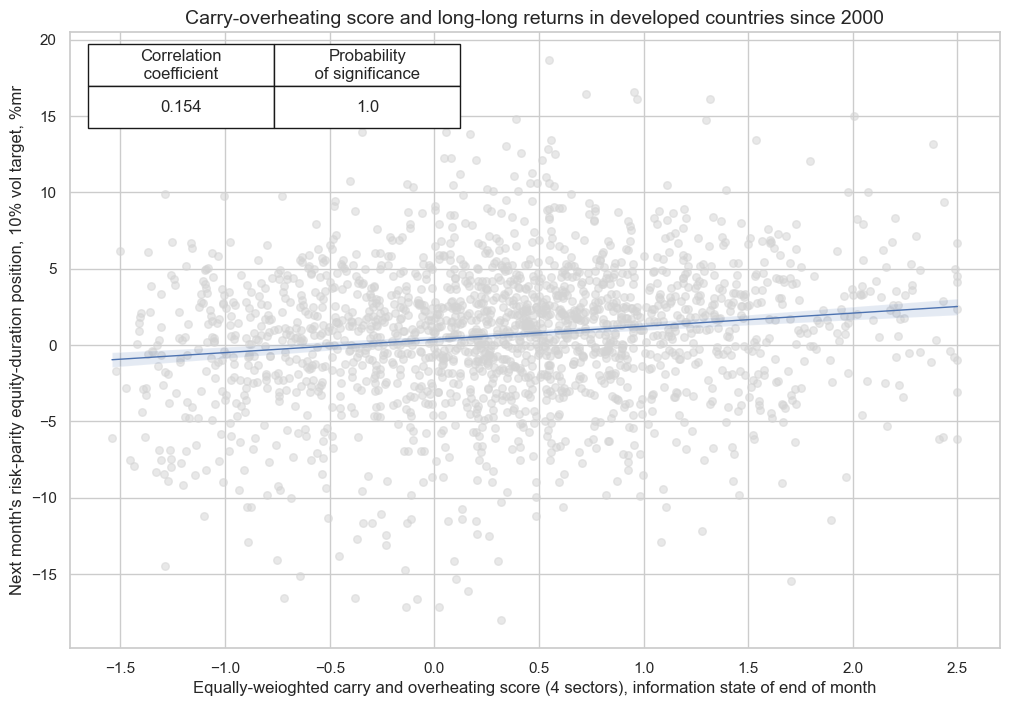

In [48]:
cr = msp.CategoryRelations(
    dfx,
    xcats=[main_feat, target],
    cids=cids,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="2004-01-01",
    xcat_trims=[None, None],
)
cr.reg_scatter(
    labels=False,
    coef_box="upper left",
    title="Carry-overheating score and long-long returns in developed countries since 2000",
    xlab="Equally-weioghted carry and overheating score (4 sectors), information state of end of month",
    ylab="Next month's risk-parity equity-duration position, 10% vol target, %mr",
)

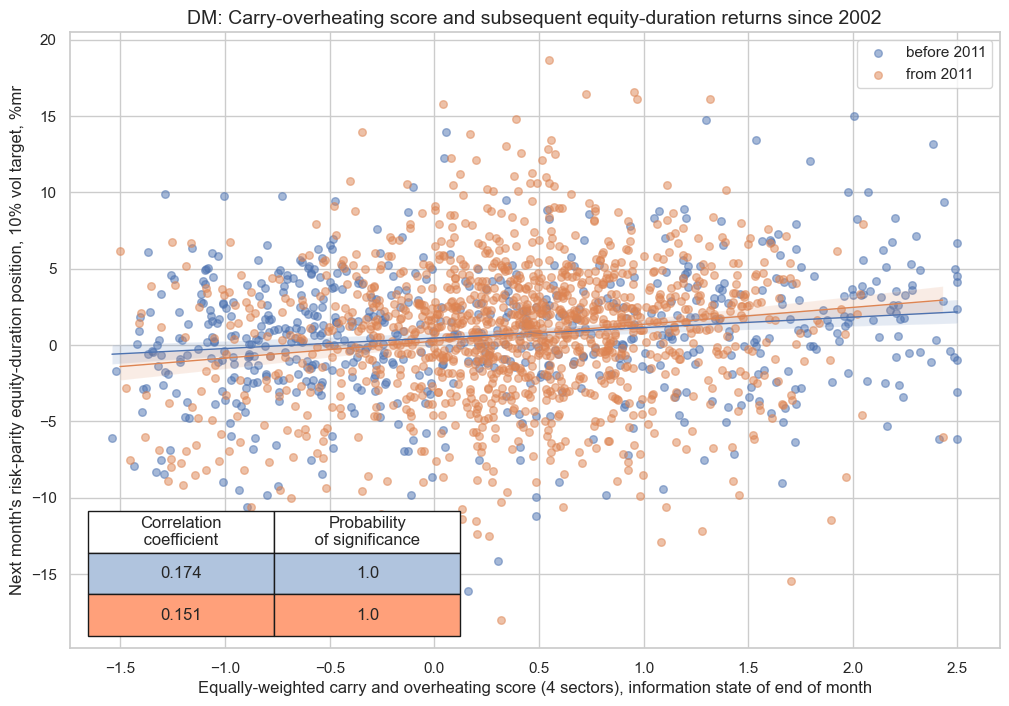

In [49]:
cr.reg_scatter(
    labels=False,
    coef_box="lower left",
    separator=2011,
    title="DM: Carry-overheating score and subsequent equity-duration returns since 2002",
    xlab="Equally-weighted carry and overheating score (4 sectors), information state of end of month",
    ylab="Next month's risk-parity equity-duration position, 10% vol target, %mr",
)

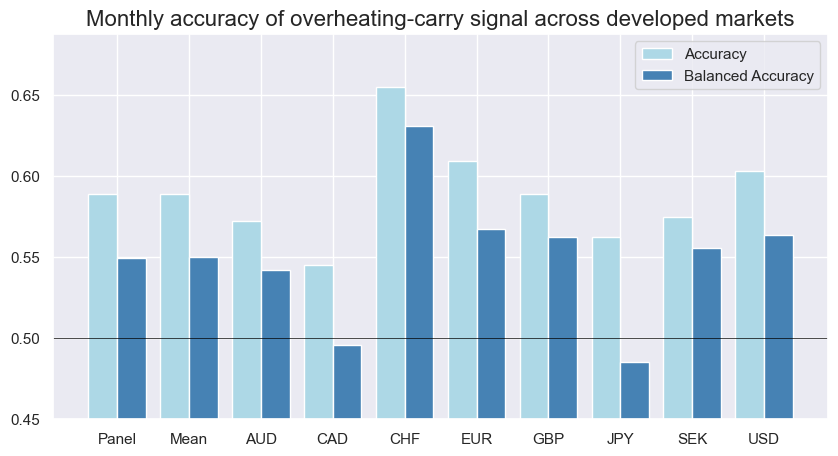

In [50]:
srr.accuracy_bars(
    type="cross_section",
    title="Monthly accuracy of overheating-carry signal across developed markets",
    size=(10, 5),
    legend_pos="best",
)

In [51]:
start_date = "2004-01-01"
sigs = feats

naive_pnl = msn.NaivePnL(
    dfx,
    ret=target,
    sigs=sigs,
    cids=cids,
    start=start_date,
    bms=["USD_EQXR_NSA"],
)

for sig in sigs:
    naive_pnl.make_pnl(
        sig,
        sig_neg=False,
        sig_op="zn_score_pan",
        thresh=2,
        rebal_freq="monthly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "_PZN",
    )

naive_pnl.make_long_pnl(vol_scale=10, label="Constant long-long")

Naïve PnL performance of the overheating-carry signal has been quite similar to the managed long-long strategy, however, we have here shorter history as equity carry signals have not been available for all countries prior to 2004.

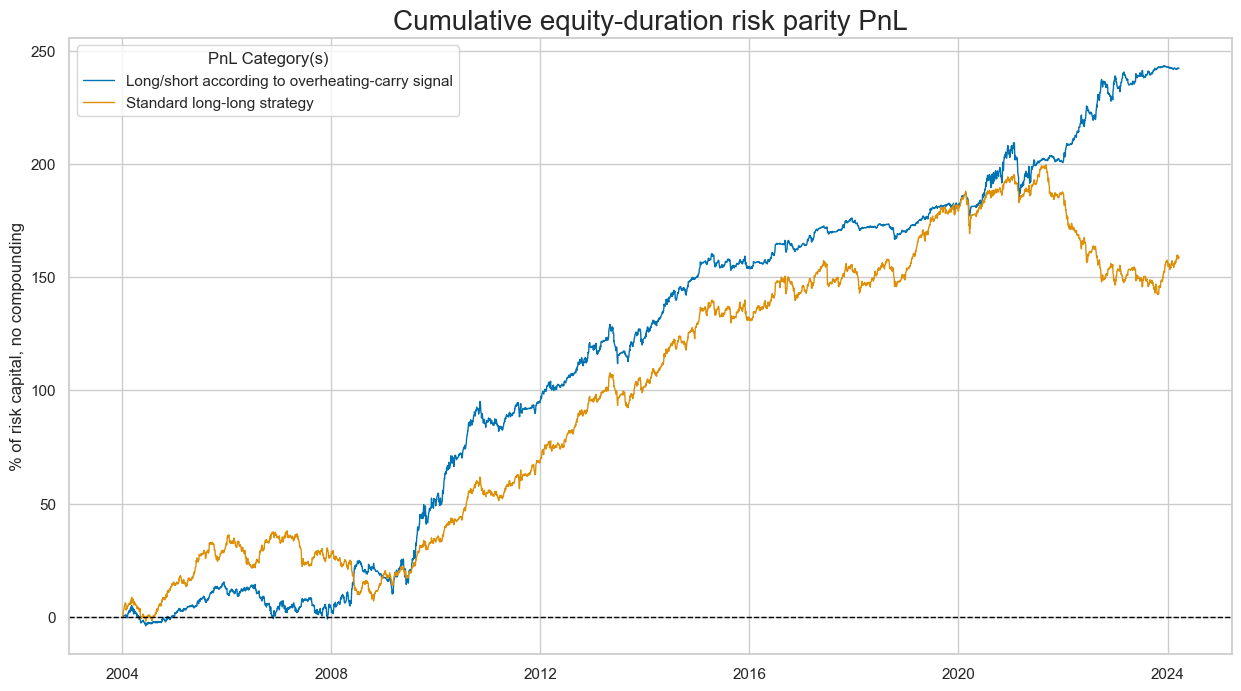

In [52]:
pnls = [sigs[0] + "_PZN"] + ["Constant long-long"]

dict_labels={"HEATCRY_CSVT10_PZN": "Long/short according to overheating-carry signal", "Constant long-long": "Standard long-long strategy"}

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start_date,
    title="Cumulative equity-duration risk parity PnL",
    xcat_labels=dict_labels,
    figsize=(15, 8),
)

In [53]:
pnls = [sig + "_PZN" for sig in sigs[:4]] + ["Constant long-long"]
df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start_date,
)

In [54]:
display(df_eval)

xcat                Constant long-long HEATCRY_CSVT10_PZN XEQDUCRY_NSAZN_PZN
Return (pct ar)               7.864435          11.982275            9.58568
St. Dev. (pct ar)                 10.0               10.0               10.0
Sharpe Ratio                  0.786443           1.198227           0.958568
Sortino Ratio                 1.088609           1.769854           1.362561
Max 21-day draw             -18.261548         -22.071487         -18.331004
Max 6-month draw             -30.44632         -13.633235         -26.222502
USD_EQXR_NSA correl           0.375618           0.125408            0.26042
Traded Months                      243                243                243